# Modelling Tracking Data for Albatross

In [32]:
import jax.numpy as jnp
from jax import Array
from jax import vmap, jit

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr
import matplotlib.cm as cm

import pickle

import os

from abc import ABC

from load_manifold import load_albatross_data

from plotting import TackPlots
from geometry.manifolds import LorentzFinslerManifold, nEllipsoid, nSphere, T2, RiemannianNavigation, nEuclidean
from geometry.tacking import SequentialOptimizationBFGS, SequentialOptimizationADAM, GEORCE_HTacking
from geometry.geodesic import GEORCE_H, GEORCE_HStep

In [26]:
figure_path = '../figures/albatross_tacking_estimation/'

In [27]:
if not (os.path.exists(figure_path)):
    os.makedirs(figure_path)

In [28]:
data_path = 'tacking_gpu/albatross/'
T = 1_000
N_sim = 5

In [29]:
Plots = TackPlots(font_size=25,
                  power_lim=-2.,
                  colors=['red', 'blue'],
                  linewidth = 2.5,
                  s = 500,
                  alpha = 1.0,
                 )

## Direction-Only Dependent Finsler Metrics

In [30]:
curve_name = 'direction_only' #'direction_only/' #'time_only/' #'poincarre/'
save_path = ''.join((data_path, curve_name, '/'))
    
onlyfiles = [f for f in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, f))]

In [31]:
file_path = ''.join((save_path, onlyfiles[0]))
with open(file_path, 'rb') as f:
    curves = pickle.load(f)

In [33]:
t0, z0, zT, Malpha, Mbeta, tack_metrics_sim, reverse_tack_metrics_sim = load_albatross_data(curve_name)

In [34]:
indicatrix_alpha = Malpha_expected.indicatrix(0.0, z0, N_points=100)#, grid=jnp.linspace(-5,5,1000), eps=1e-6)
indicatrix_beta = Mbeta_expected.indicatrix(0.0, z0, N_points=100)#, grid=jnp.linspace(-5,5,1000), eps=1e-6)

In [35]:
xscales = [-5.0, 5.0]
yscales = [-3.0, 9.0]

In [36]:
curves.keys()

dict_keys(['Geodesic', 'ReverseGeodesic', 'ExpectedTacking', 'ExpectedReverseTacking', 'Geodesic0', 'ReverseGeodesic0', 'Tacking0_1', 'ReverseTacking0_1', 'Geodesic1', 'ReverseGeodesic1', 'Tacking1_1', 'ReverseTacking1_1', 'Geodesic2', 'ReverseGeodesic2', 'Tacking2_1', 'ReverseTacking2_1', 'Geodesic3', 'ReverseGeodesic3', 'Tacking3_1', 'ReverseTacking3_1', 'Geodesic4', 'ReverseGeodesic4', 'Tacking4_1', 'ReverseTacking4_1'])

In [37]:
expected_zs = curves['Geodesic']['zs']
expected_zs_reverse = curves['ReverseGeodesic']['zs']
expected_tack_curve = curves['ExpectedTacking']['zs']
expected_reverse_tack_curve = curves['ExpectedReverseTacking']['zs']

stochastic_zs = jnp.stack([curves[f'Geodesic{i}']['zs'] for i in range(N_sim)])
stochastic_zs_reverse = jnp.stack([curves[f'ReverseGeodesic{i}']['zs'] for i in range(N_sim)])
stochastic_tack_curve = jnp.stack([curves[f'Tacking{i}_1']['zs'] for i in range(N_sim)])
stochastic_reverse_tack_curve = jnp.stack([curves[f'ReverseTacking{i}_1']['zs'] for i in range(N_sim)])

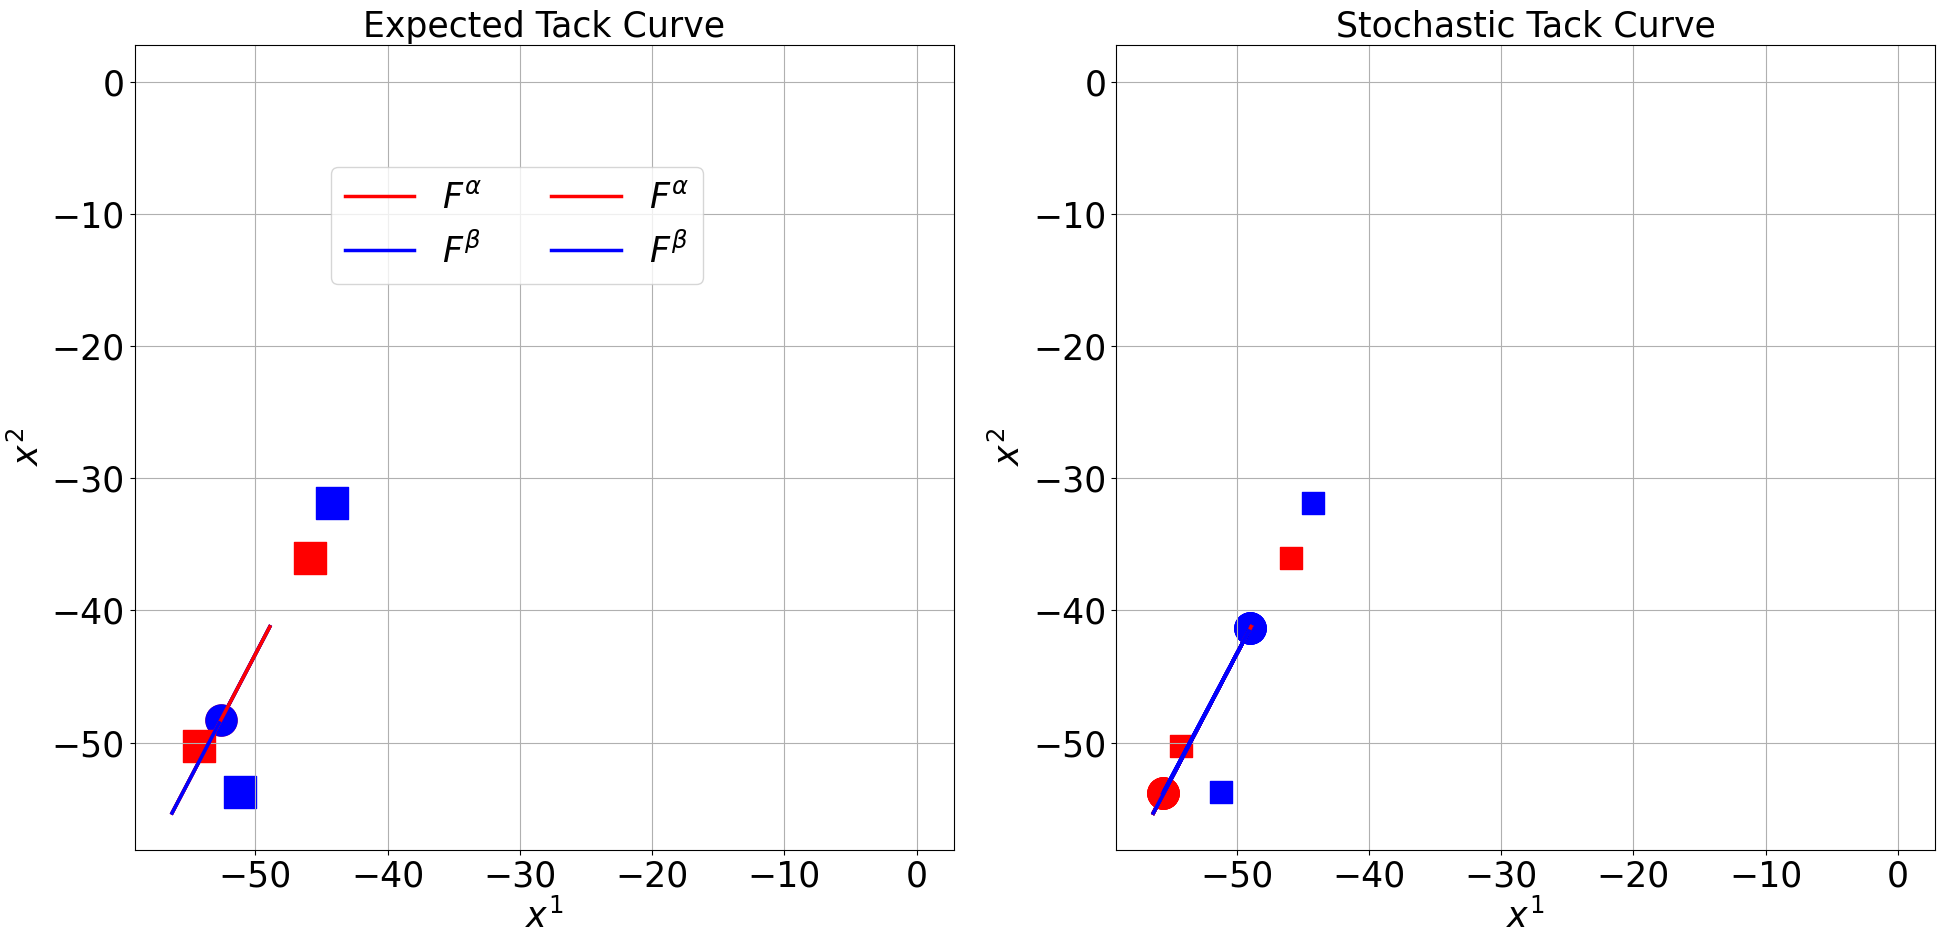

In [38]:
fig = Plots.plot_stochastic_tacking(z0,
                             zT,
                             T,
                              expected_zs,
                                expected_zs_reverse,
                                expected_tack_curve,
                                expected_reverse_tack_curve,
                                stochastic_zs,
                                stochastic_zs_reverse,
                                stochastic_tack_curve,
                                stochastic_reverse_tack_curve,
                                indicatrix_alpha=None,
                                indicatrix_beta=None,
                                xscales=None,
                                yscales=None,
                                equal_frame=False,
                                save_path=f'{figure_path}stochastic_{curve_name}.pdf',
                             )

In [1]:
import jax.numpy as jnp
from jax import Array

import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

import pandas as pd

import os

from geometry.manifolds import LorentzFinslerManifold
from geometry.tacking import SequentialOptimizationBFGS, SequentialOptimizationADAM, GEORCE_HTacking, ConstantTacking
from geometry.geodesic import GEORCE_H, GEORCE_HStep

import matplotlib.pyplot as plt

from abc import ABC

In [2]:
figure_path = 'Figures/albatross'
file_path = '../../../../Data/albatross/tracking_data.xls'

In [3]:
plt.rcParams.update({'font.size': 25})
cbformat = tkr.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2)) 

## Loading Data 

In [4]:
albatross_data = pd.read_excel(file_path)

In [5]:
albatross_data

ID  SPP_ID   SPP DTYPE SEX     RING  TRACKID  POINTID STAGE  \
0          1       1  LMSA   PTT   U  2875660  1842-43        1     P   
1          2       2  LMSA   PTT   U  2875660  1842-43        2     P   
2          3       3  LMSA   PTT   U  2875660  1842-43        3     P   
3          4       4  LMSA   PTT   U  2875660  1842-43        4     P   
4          5       5  LMSA   PTT   U  2875660  1842-43        5     P   
...      ...     ...   ...   ...  ..      ...      ...      ...   ...   
49559  49560     642   WAN   PTT   F  5092135   9294-6       37     B   
49560  49561     643   WAN   PTT   F  5092135   9294-6       38     B   
49561  49562     644   WAN   PTT   F  5092135   9294-6       39     B   
49562  49563     645   WAN   PTT   F  5092135   9294-6       40     B   
49563  49564     646   WAN   PTT   F  5092135   9294-6       41     B   

        PRP_TRP  ...   DIST_5_KM     STR_4     STR_5   FLT_DIR_2   FLT_DIR_5  \
0      0.000000  ...         NaN       NaN       NaN         NaN         NaN   
1      0.000180  ...         NaN       NaN       NaN  250.015463         NaN   
2      0.000711  ...   47.655794  0.553709       NaN  124.294351  216.042880   
3      0.003945  ...   39.801064  0.633084  0.539971  227.794938  211.492234   
4      0.005027  ...   38.431004  0.154711  0.596624  103.360732  217.727708   
...         ...  ...         ...       ...       ...         ...         ...   
49559  0.861469  ...  142.485158  0.363267  0.608613  134.551469  120.187617   
49560  0.902139  ...   97.221054  0.596972  0.465129   47.553003   87.785329   
49561  0.928798  ...   80.776590  0.606222  0.616669   66.226985   61.298995   
49562  0.963683  ...         NaN       NaN       NaN   66.701806         NaN   
49563  1.000000  ...         NaN       NaN       NaN   84.776347         NaN   

       RAW_SPD_2_MS REL_FLT_DIR_2_HRS  REL_FLT_DIR_2_DAY  REL_FLT_DIR_2_WK  \
0               NaN               NaN                NaN               NaN   
1         43.394440        144.015463          56.748982        148.326094   
2          6.478954         14.394351          68.972130         22.604981   
3          9.910928        127.294938          31.621182        125.137970   
4          7.455013          7.139268          89.905749          1.671363   
...             ...               ...                ...               ...   
49559      8.242840         75.651469                NaN               NaN   
49560      2.278346         16.046997                NaN               NaN   
49561      0.238079          2.726985                NaN               NaN   
49562      3.285985         24.398194                NaN               NaN   
49563      0.670735          6.023653                NaN               NaN   

      REL_FLT_DIR_2_MNTH  
0                    NaN  
1             124.060130  
2               1.660983  
3             109.162783  
4              22.594601  
...                  ...  
49559                NaN  
49560                NaN  
49561                NaN  
49562                NaN  
49563                NaN  

[49564 rows x 68 columns]

In [6]:
albatross_data.columns

Index(['ID', 'SPP_ID', 'SPP', 'DTYPE', 'SEX', 'RING', 'TRACKID', 'POINTID',
       'STAGE', 'PRP_TRP', 'START_TIME', 'END_TIME', 'YMDHMS', 'WEEK',
       'LATITUDE', 'LONGITUDE', 'C', 'TRACKTIME', 'INT_S', 'DATEGMT',
       'TIMEGMT', 'SUNRISE', 'SUNSET', 'DAYNIGHT', 'TWILIGHT1', 'TWILIGHT2',
       'LIGHTDARK', 'WND_SPD_KMH', 'WND_SPD_MS_5', 'WND_DIR', 'ACT_1', 'ACT_2',
       'ACT_3', 'ACT_4', 'ACT_5', 'MEAN_ACT1', 'MEAN_ACT5', 'BioDist',
       'QSWndDayDir', 'QSWndDaySpd', 'QSWeekWndDir', 'QSnWeekWndSpd',
       'QSMnthWndDir', 'QSnMnthWndSpd', 'TOX_LUX', 'SUN_LUX', 'MOON_LUX',
       'COL_DIST', 'MAX_COL_DIST', 'PRP_MAX_DIST', 'TRP_STAGE', 'INCOMP',
       'VAR_TRP_STAGE', 'COL_WND_DIR', 'COL_WND_SPD', 'HOUR', 'DIST_2_KM',
       'DIST_4_KM', 'DIST_5_KM', 'STR_4', 'STR_5', 'FLT_DIR_2', 'FLT_DIR_5',
       'RAW_SPD_2_MS', 'REL_FLT_DIR_2_HRS', 'REL_FLT_DIR_2_DAY',
       'REL_FLT_DIR_2_WK', 'REL_FLT_DIR_2_MNTH'],
      dtype='object')

In [7]:
track_id = albatross_data["TRACKID"].unique()
time_data = []
w1 = []
w2 = []
x1 = []
x2 = []
for id_val in track_id:
    dummy_data = albatross_data[albatross_data['TRACKID']==id_val].reset_index()
    t = pd.to_datetime(dummy_data['YMDHMS'], format='%Y%m%d%H%M%S')
    t = t-t.loc[0]
    time_data.append(jnp.array(t.dt.total_seconds().to_numpy()).squeeze()/3600)
    w1.append(jnp.array([dummy_data['WND_SPD_MS_5'].to_numpy()]).squeeze()*jnp.cos(dummy_data['WND_DIR'].to_numpy()/(2*jnp.pi)))
    w2.append(jnp.array([dummy_data['WND_SPD_MS_5'].to_numpy()]).squeeze()*jnp.sin(dummy_data['WND_DIR'].to_numpy()/(2*jnp.pi)))
    x1.append(jnp.array([dummy_data['LATITUDE'].to_numpy()]).squeeze())
    x2.append(jnp.array([dummy_data['LONGITUDE'].to_numpy()]).squeeze())

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [8]:
x_data = [jnp.vstack((y1,y2)).T for y1,y2 in zip(x1,x2)]
w_data = [jnp.vstack((y1,y2)).T for y1,y2 in zip(w1,w2)]

## Plotting the Data

In [9]:
bird_idx = [0,25,50]

In [10]:
#Source: https://stackoverflow.com/questions/26911898/matplotlib-curve-with-arrow-ticks

def add_arrow_to_line2D(
    axes, line, arrow_locs=[0.2, 0.4, 0.6, 0.8],
    arrowstyle='-|>', arrowsize=1, transform=None):
    """
    Add arrows to a matplotlib.lines.Line2D at selected locations.

    Parameters:
    -----------
    axes: 
    line: Line2D object as returned by plot command
    arrow_locs: list of locations where to insert arrows, % of total length
    arrowstyle: style of the arrow
    arrowsize: size of the arrow
    transform: a matplotlib transform instance, default to data coordinates

    Returns:
    --------
    arrows: list of arrows
    """
    if not isinstance(line, mlines.Line2D):
        raise ValueError("expected a matplotlib.lines.Line2D object")
    x, y = line.get_xdata(), line.get_ydata()

    arrow_kw = {
        "arrowstyle": arrowstyle,
        "mutation_scale": 10 * arrowsize,
    }

    color = line.get_color()
    use_multicolor_lines = isinstance(color, np.ndarray)
    if use_multicolor_lines:
        raise NotImplementedError("multicolor lines not supported")
    else:
        arrow_kw['color'] = color

    linewidth = line.get_linewidth()
    if isinstance(linewidth, np.ndarray):
        raise NotImplementedError("multiwidth lines not supported")
    else:
        arrow_kw['linewidth'] = linewidth

    if transform is None:
        transform = axes.transData

    arrows = []
    for loc in arrow_locs:
        s = np.cumsum(np.sqrt(np.diff(x) ** 2 + np.diff(y) ** 2))
        n = np.searchsorted(s, s[-1] * loc)
        arrow_tail = (x[n], y[n])
        arrow_head = (np.mean(x[n:n + 2]), np.mean(y[n:n + 2]))
        p = mpatches.FancyArrowPatch(
            arrow_tail, arrow_head, transform=transform,
            **arrow_kw)
        axes.add_patch(p)
        arrows.append(p)
    return arrows

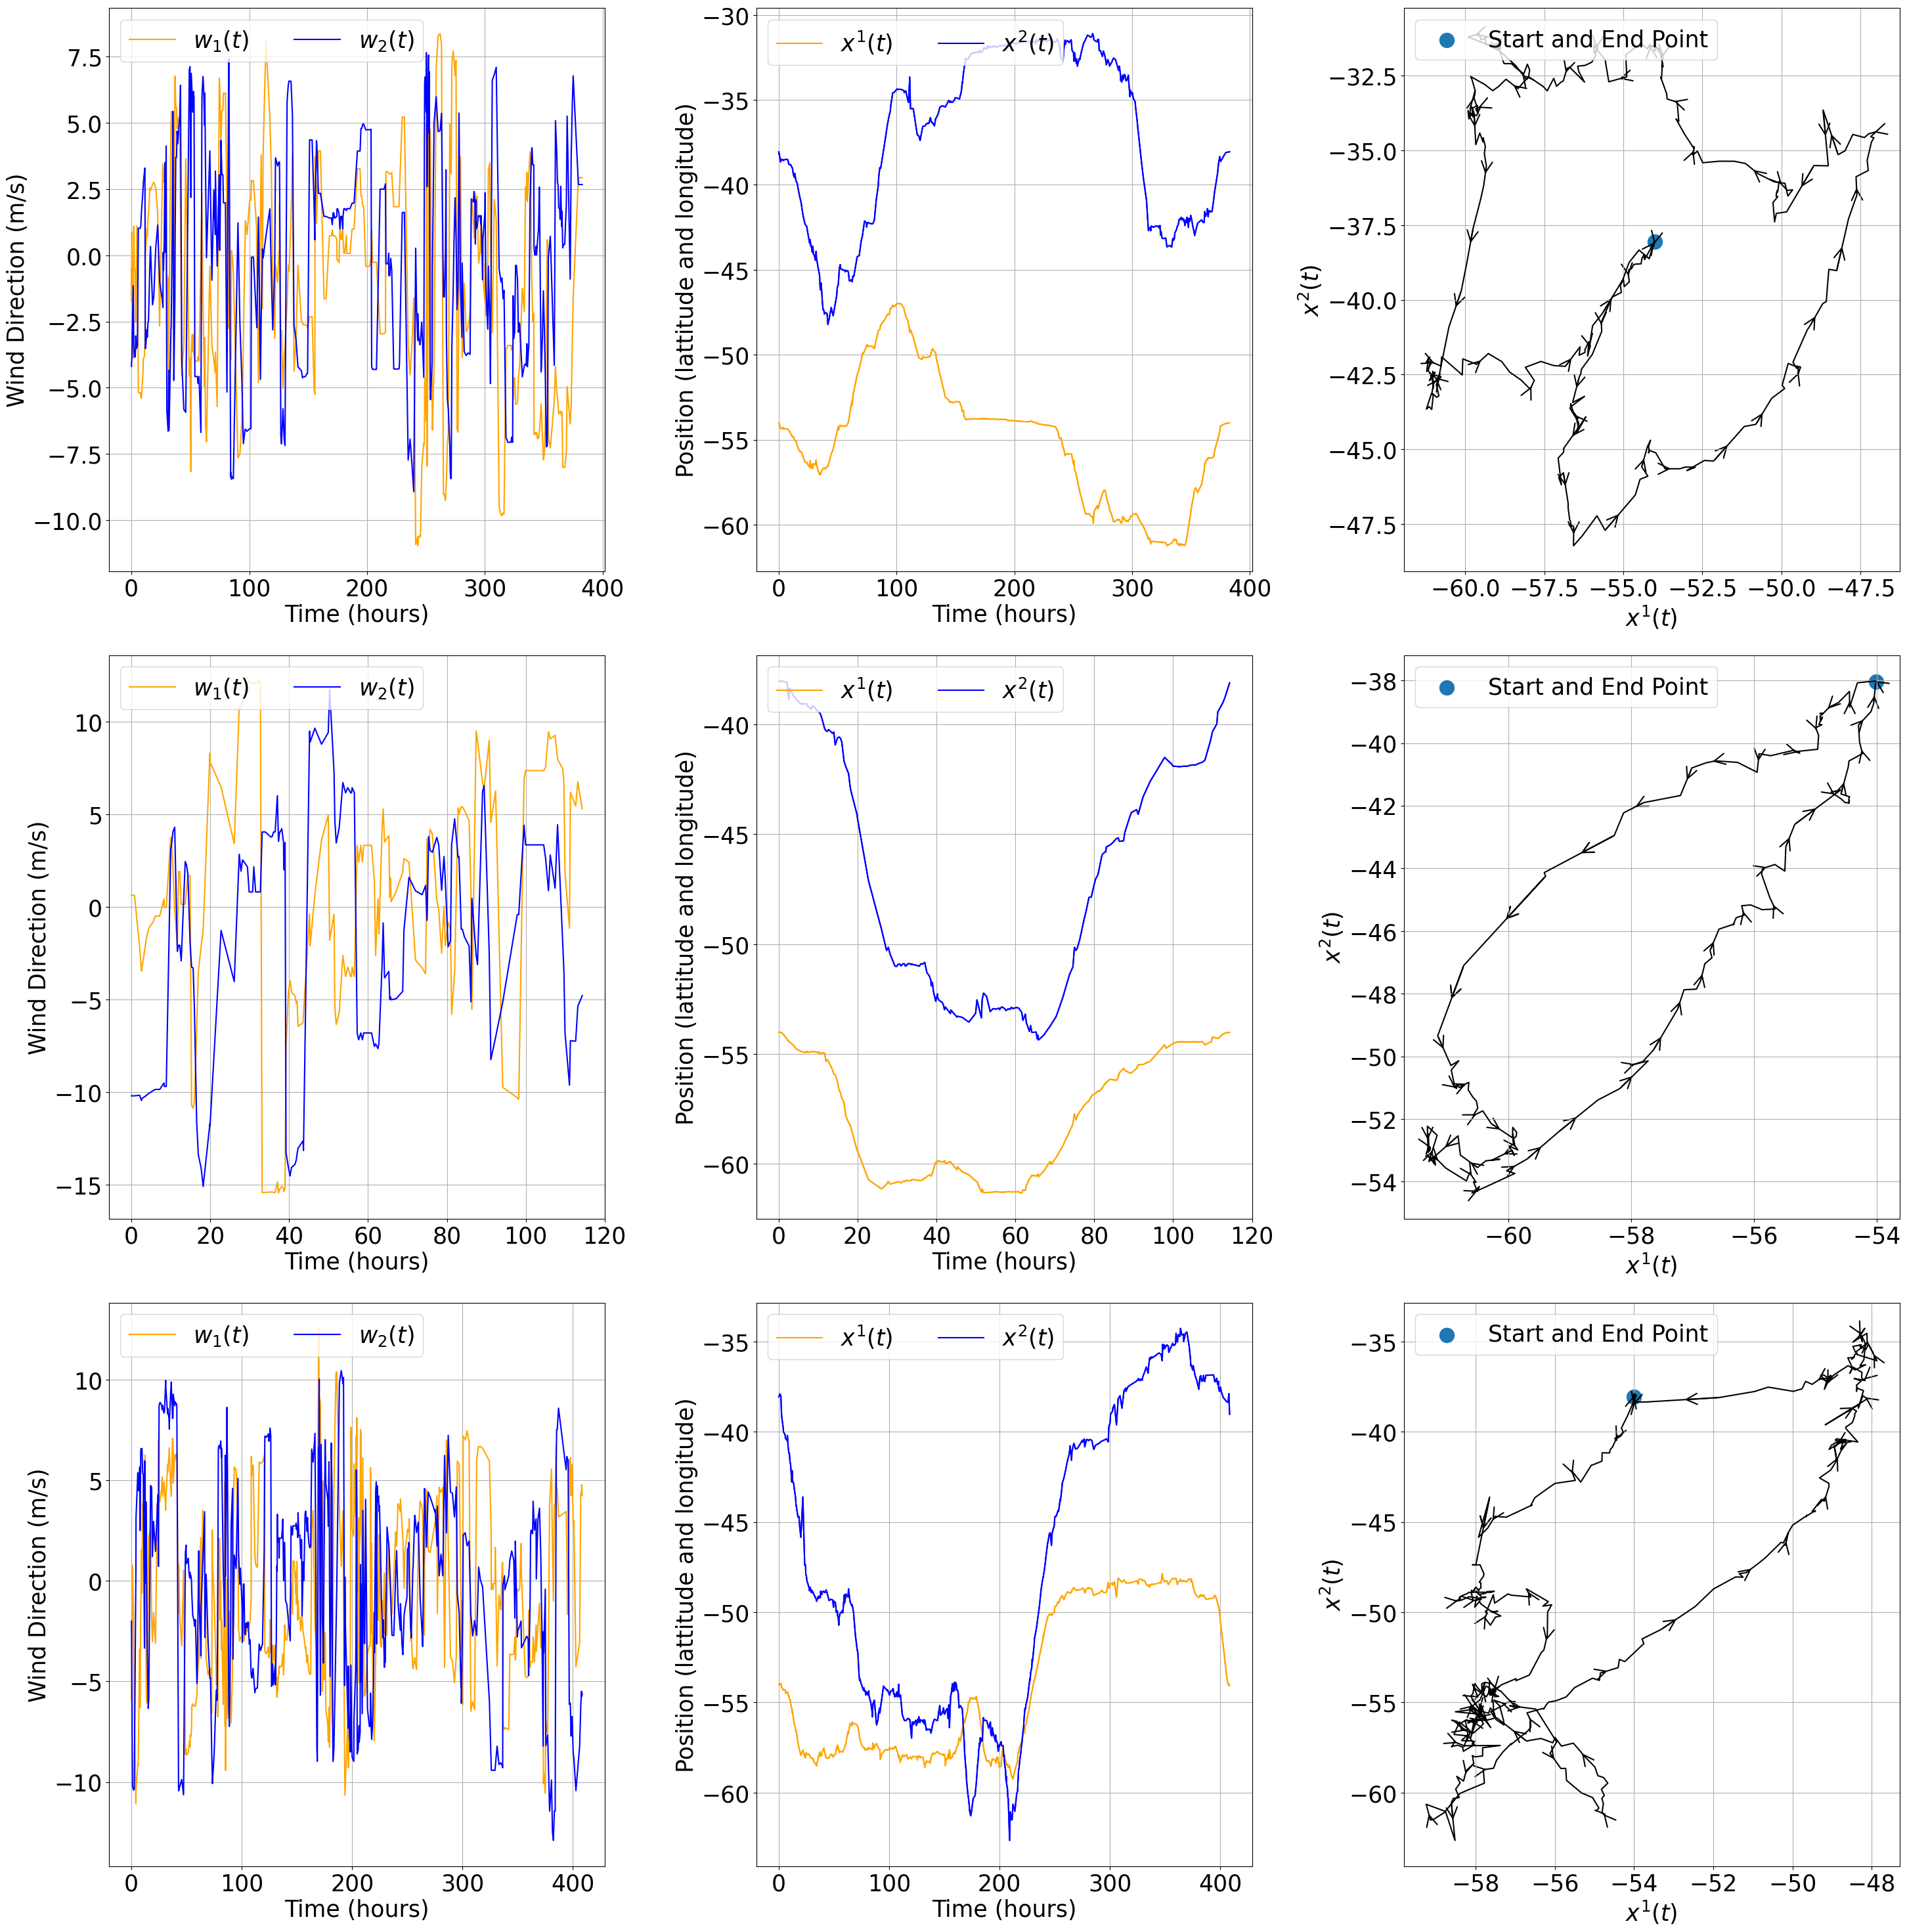

In [11]:
fig = plt.figure(figsize=(len(bird_idx)*10,len(bird_idx)*10))

for i in range(len(bird_idx)):
    idx = bird_idx[i]
    ax = fig.add_subplot(3,3,len(bird_idx)*i+1)
    ax.plot(time_data[idx], w1[idx], color='orange', label=f'$w_{1}(t)$')
    ax.plot(time_data[idx], w2[idx], color='blue', label=f'$w_{2}(t)$')
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('Wind Direction (m/s)')
    ax.grid(True)
    ax.legend(loc="upper left", ncol=2)

    ax = fig.add_subplot(3,3,len(bird_idx)*i+2)
    ax.plot(time_data[idx], x1[idx], color='orange')
    ax.plot(time_data[idx], x2[idx], color='blue')
    ax.plot(time_data[idx], x1[idx], color='orange', label=f'$x^{1}(t)$')
    ax.plot(time_data[idx], x2[idx], color='blue', label=f'$x^{2}(t)$')
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('Position (lattitude and longitude)')
    ax.grid(True)
    ax.legend(loc="upper left", ncol=2)

    ax = fig.add_subplot(3,3,len(bird_idx)*i+3)
    ax.scatter(x1[idx][0], x2[idx][0], s=250, label="Start and End Point")
    line, = ax.plot(x1[idx], x2[idx], 'k-')
    add_arrow_to_line2D(ax, line, arrow_locs=np.linspace(0., 1., 50),
                        arrowstyle='->', arrowsize=3)
    ax.set_xlabel(f'$x^{1}(t)$')
    ax.set_ylabel(f'$x^{2}(t)$')
    ax.grid(True)
    ax.legend(loc="upper left", ncol=2)

fig.tight_layout()

fig.savefig(os.path.join(figure_path, 'bird_data.pdf'), format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()

## Estimating Tack Curves

In [12]:
data_idx = {bird_idx[0]: [[67,90], [149, 195], [315, 335]],
           bird_idx[1]: [[30, 40], [115, 140], [140, 160]],
           bird_idx[2]: [[15, 35], [92, 108], [325, 370]]}
v_min = 0.0
v_max = 20.0
v_mean= v_max/2
v_slope = 0.25

### Defining The Metric

In [13]:
class LeftMetric(ABC):
    def __init__(self,
                 t:Array,
                 w:Array,
                 v_min:float=v_min,
                 v_max:float=v_max,
                 v_mean:float=v_mean,
                 v_slope:float=v_slope,
                )->None:
        
        if t.ndim == 0:
            self.interp = lambda s: w
        elif len(t)==2:
            self.interp = lambda s: (1.-s)*w[0]+s*w[1]
        else:
            
            t = jnp.linspace(0.,1.,len(w),endpoint=True)
            
            self.interp = lambda s: jnp.vstack((jnp.interp(s, t, w.T[0].reshape(len(t))),
                                                jnp.interp(s, t, w.T[1].reshape(len(t))),
                                               ))

        self.v_min = v_min
        self.v_max = v_max
        self.v_mean = v_mean
        self.v_slope = v_slope
        
    def frac_fun(self, v_norm):
        
        return self.v_min/self.v_max+1.0/(1+jnp.exp(-self.v_slope*(v_norm-self.v_mean)))
        
    def metric(self, v):
        
        v_norm = jnp.linalg.norm(v)
        
        frac = self.frac_fun(v_norm)
        
        #v /= 111111
        #v_norm = jnp.linalg.norm(v)
        
        a=v_norm
        b=v_norm
        c1=frac*v_norm
        c2=-frac*v_norm*jnp.sqrt((1-frac**2))
        theta = (jnp.pi/2-jnp.arctan(v[1]/v[0]))#-jnp.pi/4
        
        return a,b,c1,c2,theta
        
    def __call__(self, t, x, v, s):
        
        
        w = self.interp(s)
        
        a,b,c1,c2,theta = self.metric(w)
        
        x,y = v[0], v[1]
        
        a2 = a**2
        b2 = b**2
        a4 = a**4
        b4 = b**4
        c12 = c1**2
        c22 = c2**2

        f = (-a2*c2*(x*jnp.sin(theta)+y*jnp.cos(theta))-\
             b2*c1*(x*jnp.cos(theta)-y*jnp.sin(theta))+\
             (a4*b2*(x*jnp.sin(theta)+y*jnp.cos(theta))**2+\
              a2*b4*(x*jnp.cos(theta)-y*jnp.sin(theta))**2-\
              a2*b2*c12*(x*jnp.sin(theta)+y*jnp.cos(theta))**2+\
              2*a2*b2*c1*c2*(x*jnp.cos(theta)-y*jnp.sin(theta))*(x*jnp.sin(theta)+y*jnp.cos(theta))-\
              a2*b2*c22*(x*jnp.cos(theta)-y*jnp.sin(theta))**2)**(1/2))/(a2*b2-a2*c22-b2*c12)
        
        return f.squeeze()

In [14]:
class RightMetric(ABC):
    def __init__(self,
                 t:Array,
                 w:Array,
                 v_min:float = v_min,
                 v_max:float = v_max,
                 v_mean:float = v_mean,
                 v_slope:float = v_slope,
                )->None:
        
        if t.ndim == 0:
            self.interp = lambda s: w
        elif len(t) == 2:
            self.interp = lambda s: (1.-s)*w[0]+s*w[1]
        else:
            t = jnp.linspace(0.,1.,len(w),endpoint=True)
            
            self.interp = lambda s: jnp.vstack((jnp.interp(s, t, w.T[0].reshape(len(t))),
                                                jnp.interp(s, t, w.T[1].reshape(len(t))),
                                               ))

        self.v_min = v_min
        self.v_max = v_max
        self.v_mean = v_mean
        self.v_slope = v_slope
        
    def frac_fun(self, v_norm):
        
        return self.v_min/self.v_max+1.0/(1+jnp.exp(-self.v_slope*(v_norm-self.v_mean)))
        
    def metric(self, v):
        
        v_norm = jnp.linalg.norm(v)
        
        frac = self.frac_fun(v_norm)
        
        #v /= 111111
        #v_norm = jnp.linalg.norm(v)
        
        a=v_norm
        b=v_norm
        c1=-frac*v_norm
        c2=-frac*v_norm*jnp.sqrt((1-frac**2))
        theta = (jnp.pi/2-jnp.arctan(v[1]/v[0]))#-jnp.pi/4
        
        return a,b,c1,c2,theta
        
    def __call__(self, t, x, v, s):
        
        w = self.interp(s)

        a, b, c1, c2, theta = self.metric(w)
        
        x,y = v[0], v[1]
        
        a2 = a**2
        b2 = b**2
        a4 = a**4
        b4 = b**4
        c12 = c1**2
        c22 = c2**2

        f = (-a2*c2*(x*jnp.sin(theta)+y*jnp.cos(theta))-\
             b2*c1*(x*jnp.cos(theta)-y*jnp.sin(theta))+\
             (a4*b2*(x*jnp.sin(theta)+y*jnp.cos(theta))**2+\
              a2*b4*(x*jnp.cos(theta)-y*jnp.sin(theta))**2-\
              a2*b2*c12*(x*jnp.sin(theta)+y*jnp.cos(theta))**2+\
              2*a2*b2*c1*c2*(x*jnp.cos(theta)-y*jnp.sin(theta))*(x*jnp.sin(theta)+y*jnp.cos(theta))-\
              a2*b2*c22*(x*jnp.cos(theta)-y*jnp.sin(theta))**2)**(1/2))/(a2*b2-a2*c22-b2*c12)
        
        return f.squeeze()

### Plotting the Constructed Metrics

In [15]:
idx_val = 0

In [16]:
start_idx = data_idx[bird_idx[idx_val]][0][0]
end_idx = data_idx[bird_idx[idx_val]][0][1]

In [17]:
Falpha = LeftMetric(t=jnp.hstack((time_data[bird_idx[idx_val]][start_idx],
                                  time_data[bird_idx[idx_val]][end_idx],
                                 )),
                    w=jnp.vstack((w_data[bird_idx[idx_val]][start_idx],
                                  w_data[bird_idx[idx_val]][end_idx],
                                 ))
                   )
Malpha = LorentzFinslerManifold(F=Falpha)

In [18]:
Fbeta = RightMetric(t=jnp.hstack((time_data[bird_idx[idx_val]][start_idx],
                                  time_data[bird_idx[idx_val]][end_idx],
                                 )),
                    w=jnp.vstack((w_data[bird_idx[idx_val]][start_idx],
                                  w_data[bird_idx[idx_val]][end_idx],
                                 ))
                   )
Mbeta = LorentzFinslerManifold(F=Fbeta)

In [19]:
v_start = w_data[bird_idx[idx_val]][data_idx[bird_idx[idx_val]][0][0]]
v_end = w_data[bird_idx[idx_val]][data_idx[bird_idx[idx_val]][0][1]]
x_start = x_data[bird_idx[idx_val]][data_idx[bird_idx[idx_val]][0][0]]
x_end = x_data[bird_idx[idx_val]][data_idx[bird_idx[idx_val]][0][1]]

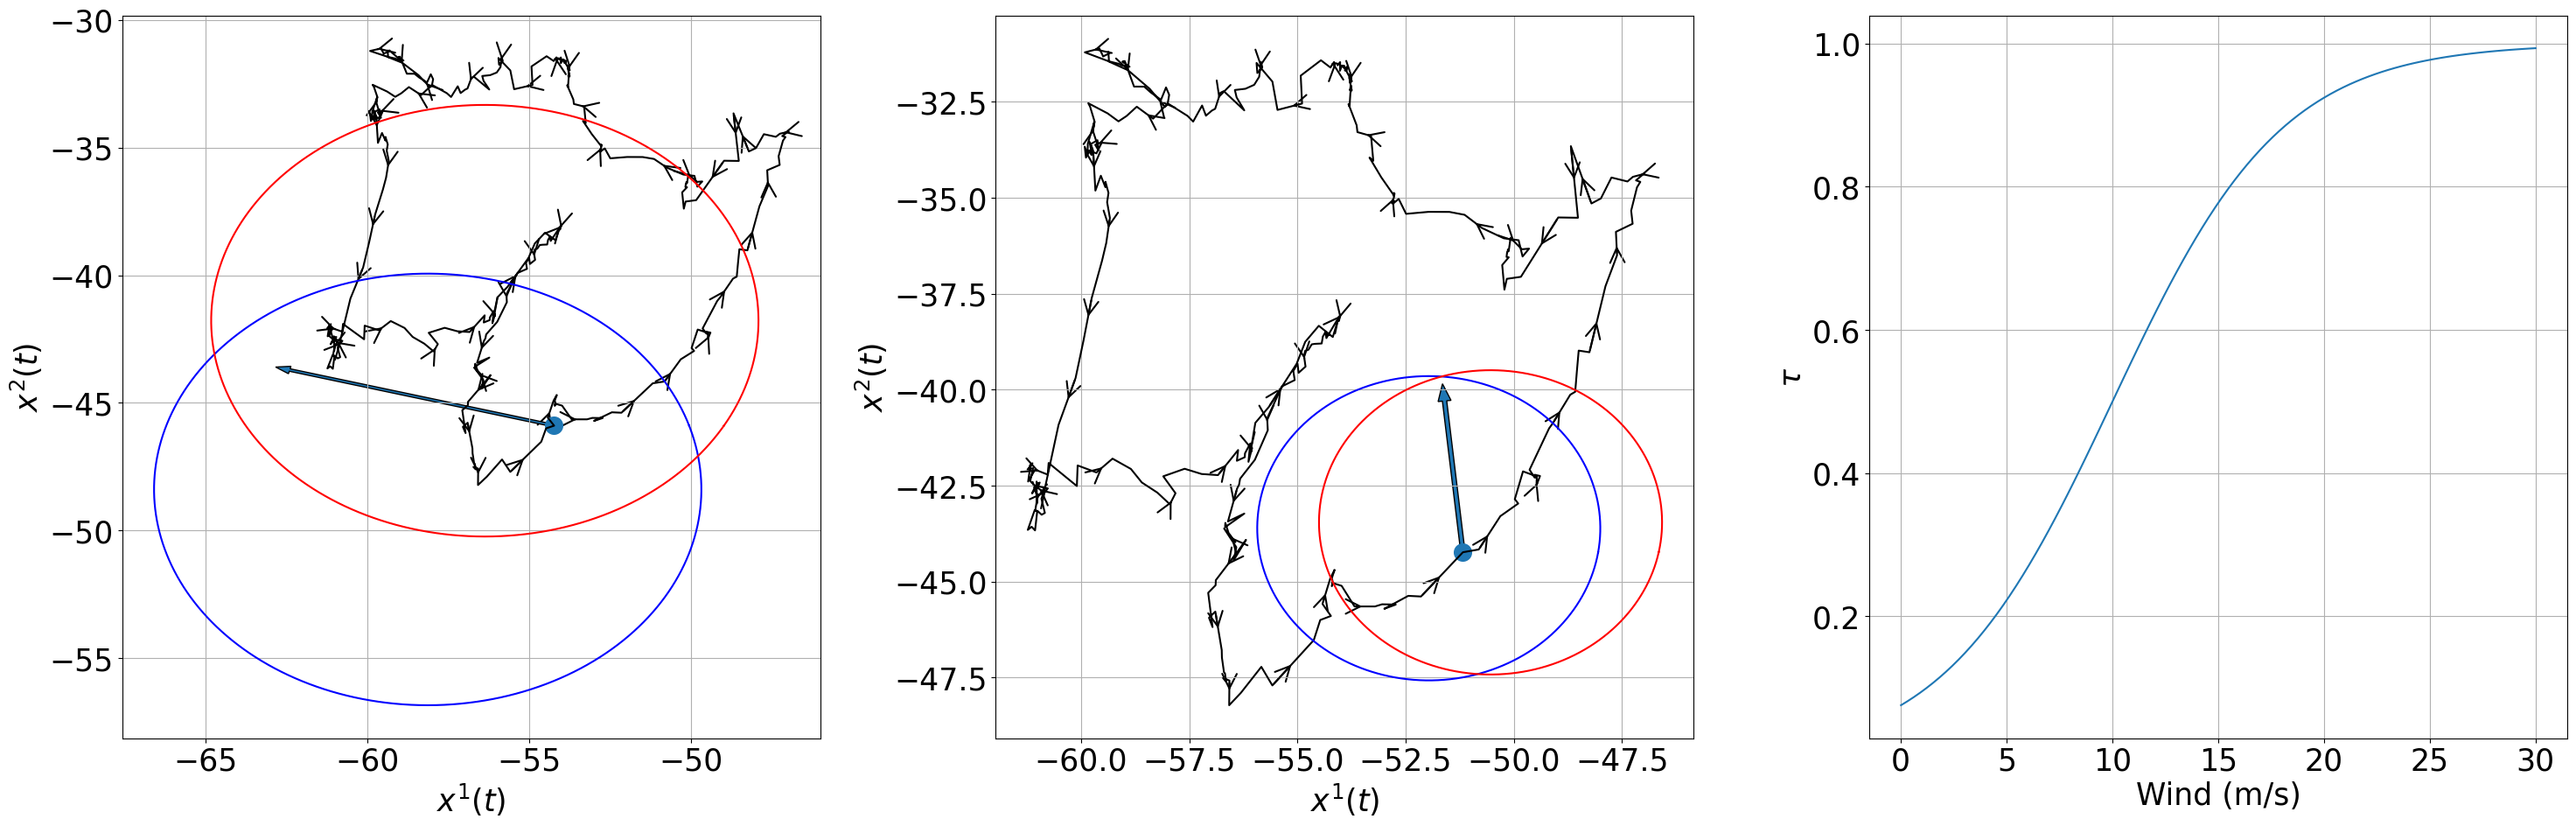

In [20]:
s_steps = [0.0, 1.0]
x_points = [x_start, x_end]
v_points = [v_start, v_end]

fig = plt.figure(figsize=((len(s_steps)+1)*10,10))

for i in range(len(s_steps)):
    ax = fig.add_subplot(1,len(s_steps)+1,i+1)
    indicatrix_alpha = Malpha.indicatrix(0.0, x_points[i], s_steps[i], N_points=100000)#, grid=jnp.linspace(-5,5,1000), eps=1e-6)
    indicatrix_beta = Mbeta.indicatrix(0.0, x_start, s_steps[i], N_points=100000)#, grid=jnp.linspace(-5,5,1000), eps=1e-6)
    line, = ax.plot(x1[bird_idx[idx_val]], x2[bird_idx[idx_val]], 'k-')
    add_arrow_to_line2D(ax, line, arrow_locs=np.linspace(0., 1., 50),
                        arrowstyle='->', arrowsize=3)
    ax.set_xlabel(f'$x^{1}(t)$')
    ax.set_ylabel(f'$x^{2}(t)$')
    ax.grid(True)
    #ax.legend(loc="upper left", ncol=2)

    ax.plot(x_points[i][0]+indicatrix_alpha[:,0], x_points[i][1]+indicatrix_alpha[:,1], color="blue")
    ax.plot(x_points[i][0]+indicatrix_beta[:,0], x_points[i][1]+indicatrix_beta[:,1], color="red")
    ax.arrow(x_points[i][0], x_points[i][1], v_points[i][0], v_points[i][1], width = 0.1)
    ax.scatter(x_points[i][0],x_points[i][1], s=200)
    
wind_test = jnp.linspace(0.0,30.0,100)
tau = v_min/v_max+1.0/(1+jnp.exp(-v_slope*(wind_test-v_mean)))

ax = fig.add_subplot(133)
ax.plot(wind_test, tau)
ax.set_xlabel('Wind (m/s)')
ax.set_ylabel(r"$\tau$")
ax.grid(True)
    
fig.tight_layout()

fig.savefig(os.path.join(figure_path, 'bird_metric.pdf'), format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()

## Estimating Tack Curves

In [28]:
T = 1000
max_iter = 100
tol = 1e-4

### Estimating Tack Curves for Constant Metrics

#### Estimating Energy Tack Curves

In [29]:
energy_curves = {}
for keys, val in data_idx.items():
    tack_curves = []
    reverse_tack_curves = []
    geodesic_curves = []
    reverse_geodesic_curves = []
    for l in val:
        
        t0 = jnp.zeros(1, dtype=jnp.float64).squeeze()
        z0 = x_data[keys][l[0]]
        zT = x_data[keys][l[1]]
        
        t_val = jnp.mean(time_data[keys], axis=0)
        w_val = jnp.mean(w_data[keys], axis=0)
        
        #t_val = time_data[keys][l[0]]
        #w_val = w_data[keys][l[0]]
        
        Falpha = LeftMetric(t=t_val, w=w_val)
        Malpha = LorentzFinslerManifold(F=Falpha)

        Fbeta = RightMetric(t=t_val, w=w_val)
        Mbeta = LorentzFinslerManifold(F=Fbeta)
        
        tack_metrics = [Malpha, Mbeta]
        reverse_tack_metrics = [Mbeta, Malpha]
        
        Geodesic = GEORCE_H(Malpha, init_fun=None, T=T, tol=tol, max_iter=max_iter, line_search_params={'rho': 0.5})
        ReverseGeodesic = GEORCE_H(Mbeta, init_fun=None, T=T, tol=tol, max_iter=max_iter, line_search_params={'rho': 0.5})
        
        EnergyTacking = GEORCE_HTacking(tack_metrics, init_fun=None, T=T, tol=tol, max_iter=max_iter, line_search_params={'rho': 0.5})
        EnergyReverseTacking = GEORCE_HTacking(reverse_tack_metrics, init_fun=None, T=T, tol=tol, max_iter=max_iter, line_search_params={'rho': 0.5})
        
        print(f"Computing geodesics...")
        zt1 = Geodesic(t0, z0, zT)
        zt2 = ReverseGeodesic(t0, z0, zT)
        print(f"\t -Tavel time for geodesic curve: {zt1[0][-1]:.4f}")
        print(f"\t -Tavel time for reverse geodesic curve: {zt2[0][-1]:.4f}")
        print(f"\t -Idx for geodesic curve: {zt1[-1]}")
        print(f"\t -Idx for reverse geodesic curve: {zt2[-1]}")
        print(f"\t -Grad for geodesic curve: {jnp.linalg.norm(zt1[-2]):.4f}")
        print(f"\t -Grad for reverse geodesic curve: {jnp.linalg.norm(zt2[-2]):.4f}")
        geodesic_curves.append(zt1[1])
        reverse_geodesic_curves.append(zt2[1])
        
        zt1 = EnergyTacking(t0, z0, zT, n_tacks=1)
        zt2 = EnergyReverseTacking(t0, z0, zT, n_tacks=1)
        print(f"\t -Tavel time for tack curve: {zt1[0][-1]:.4f}")
        print(f"\t -Tavel time for reverse tack curve: {zt2[0][-1]:.4f}")
        print(f"\t -Idx for tack curve: {zt1[-1]}")
        print(f"\t -Idx for reverse tack curve: {zt2[-1]}")
        print(f"\t -Grad for tack curve: {jnp.linalg.norm(zt1[-2]):.4f}")
        print(f"\t -Grad for reverse tack curve: {jnp.linalg.norm(zt2[-2]):.4f}")
        
        tack_curves.append(zt1[1])
        reverse_tack_curves.append(zt2[1])
    
    energy_curves[keys] = {'tack_curves': tack_curves,
                            'reverse_tack_curves': reverse_tack_curves,
                            'geodesic_curves': geodesic_curves,
                            'reverse_geodesic_curves': reverse_geodesic_curves,
                            }
        

Computing geodesics...
	 -Tavel time for geodesic curve: 3.2297
	 -Tavel time for reverse geodesic curve: 2.9905
	 -Idx for geodesic curve: 0
	 -Idx for reverse geodesic curve: 0
	 -Grad for geodesic curve: 0.0000
	 -Grad for reverse geodesic curve: 0.0000
	 -Tavel time for tack curve: 3.0862
	 -Tavel time for reverse tack curve: 3.0861
	 -Idx for tack curve: 1
	 -Idx for reverse tack curve: 1
	 -Grad for tack curve: 0.0000
	 -Grad for reverse tack curve: 0.0000
Computing geodesics...
	 -Tavel time for geodesic curve: 4.5852
	 -Tavel time for reverse geodesic curve: 3.8776
	 -Idx for geodesic curve: 0
	 -Idx for reverse geodesic curve: 0
	 -Grad for geodesic curve: 0.0000
	 -Grad for reverse geodesic curve: 0.0000
	 -Tavel time for tack curve: 4.1666
	 -Tavel time for reverse tack curve: 4.1663
	 -Idx for tack curve: 1
	 -Idx for reverse tack curve: 1
	 -Grad for tack curve: 0.0000
	 -Grad for reverse tack curve: 0.0000
Computing geodesics...
	 -Tavel time for geodesic curve: 6.4428
	 

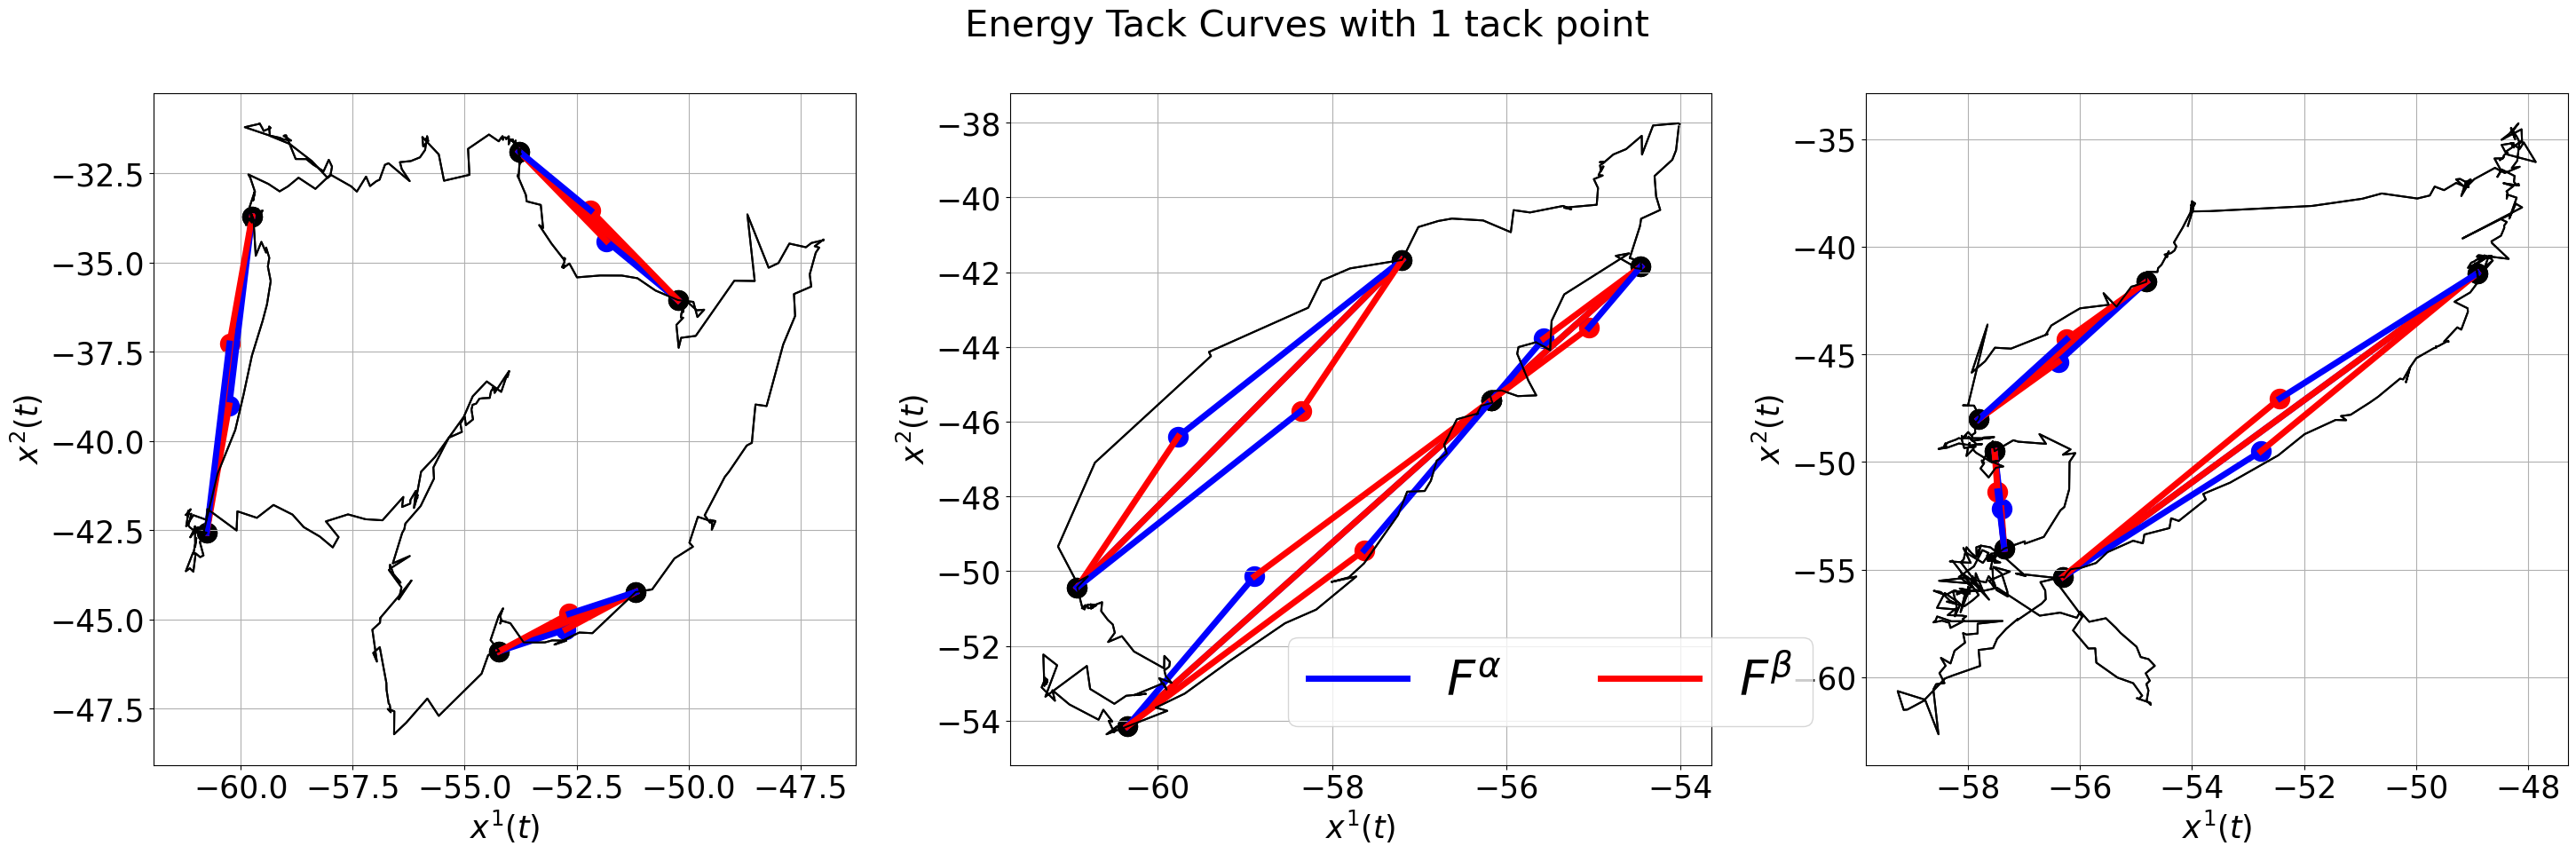

In [30]:
fig = plt.figure(figsize=(len(bird_idx)*10,10))

for i in range(len(bird_idx)):
    ax = fig.add_subplot(1,3,i+1)
    
    ax.plot(energy_curves[bird_idx[i]]['geodesic_curves'][0][:,0], energy_curves[bird_idx[i]]['geodesic_curves'][0][:,1], 
            color='blue', linewidth=5.)
    ax.scatter(energy_curves[bird_idx[i]]['geodesic_curves'][0][0,0], energy_curves[bird_idx[i]]['geodesic_curves'][0][0,1], 
                color='black', s=250)
    ax.scatter(energy_curves[bird_idx[i]]['geodesic_curves'][0][-1,0], energy_curves[bird_idx[i]]['geodesic_curves'][0][-1,1], 
                color='black', s=250)
    
    ax.plot(energy_curves[bird_idx[i]]['geodesic_curves'][1][:,0], energy_curves[bird_idx[i]]['geodesic_curves'][1][:,1], 
            color='blue', linewidth=5.)
    ax.scatter(energy_curves[bird_idx[i]]['geodesic_curves'][1][0,0], energy_curves[bird_idx[i]]['geodesic_curves'][1][0,1], 
            color='black', s=250)
    ax.scatter(energy_curves[bird_idx[i]]['geodesic_curves'][1][-1,0], energy_curves[bird_idx[i]]['geodesic_curves'][1][-1,1], 
            color='black', s=250)
    
    
    ax.plot(energy_curves[bird_idx[i]]['geodesic_curves'][2][:,0], energy_curves[bird_idx[i]]['geodesic_curves'][2][:,1], 
            color='blue', linewidth=5.)
    ax.scatter(energy_curves[bird_idx[i]]['geodesic_curves'][2][0,0], energy_curves[bird_idx[i]]['geodesic_curves'][2][0,1], 
                color='black', s=250)
    ax.scatter(energy_curves[bird_idx[i]]['geodesic_curves'][2][-1,0], energy_curves[bird_idx[i]]['geodesic_curves'][2][-1,1], 
                color='black', s=250)

    ax.plot(energy_curves[bird_idx[i]]['reverse_geodesic_curves'][0][:,0], energy_curves[bird_idx[i]]['reverse_geodesic_curves'][0][:,1],
            color='red', linewidth=5.)
    ax.plot(energy_curves[bird_idx[i]]['reverse_geodesic_curves'][1][:,0], energy_curves[bird_idx[i]]['reverse_geodesic_curves'][1][:,1],
           color='red', linewidth=5.)
    ax.plot(energy_curves[bird_idx[i]]['reverse_geodesic_curves'][2][:,0], energy_curves[bird_idx[i]]['reverse_geodesic_curves'][2][:,1],
           color='red', linewidth=5.)

    ax.plot(x_data[bird_idx[i]][:,0], x_data[bird_idx[i]][:,1], 'black')
    
    ax.plot(energy_curves[bird_idx[i]]['tack_curves'][0][:T,0], energy_curves[bird_idx[i]]['tack_curves'][0][:T,1], 
            color='blue', linewidth=5.)
    ax.scatter(energy_curves[bird_idx[i]]['tack_curves'][0][T,0], energy_curves[bird_idx[i]]['tack_curves'][0][T,1], 
            color='blue', s=250.)
    ax.plot(energy_curves[bird_idx[i]]['tack_curves'][0][T:,0], energy_curves[bird_idx[i]]['tack_curves'][0][T:,1], 
            color='red', linewidth=5.)
    ax.scatter(energy_curves[bird_idx[i]]['tack_curves'][0][0,0], energy_curves[bird_idx[i]]['tack_curves'][0][0,1], 
                color='black', s=250)
    ax.scatter(energy_curves[bird_idx[i]]['tack_curves'][0][-1,0], energy_curves[bird_idx[i]]['tack_curves'][0][-1,1], 
                color='black', s=250)
    
    ax.plot(energy_curves[bird_idx[i]]['tack_curves'][1][:T,0], energy_curves[bird_idx[i]]['tack_curves'][1][:T,1], 
            color='blue', linewidth=5.)
    ax.scatter(energy_curves[bird_idx[i]]['tack_curves'][1][T,0], energy_curves[bird_idx[i]]['tack_curves'][1][T,1], 
            color='blue', s=250.)
    ax.plot(energy_curves[bird_idx[i]]['tack_curves'][1][T:,0], energy_curves[bird_idx[i]]['tack_curves'][1][T:,1], 
            color='red', linewidth=5.)
    ax.scatter(energy_curves[bird_idx[i]]['tack_curves'][1][0,0], energy_curves[bird_idx[i]]['tack_curves'][1][0,1], 
            color='black', s=250)
    ax.scatter(energy_curves[bird_idx[i]]['tack_curves'][1][-1,0], energy_curves[bird_idx[i]]['tack_curves'][1][-1,1], 
            color='black', s=250)
    
    
    ax.plot(energy_curves[bird_idx[i]]['tack_curves'][2][:T,0], energy_curves[bird_idx[i]]['tack_curves'][2][:T,1], 
            color='blue', linewidth=5.)
    ax.scatter(energy_curves[bird_idx[i]]['tack_curves'][2][T,0], energy_curves[bird_idx[i]]['tack_curves'][2][T,1], 
            color='blue', s=250.)
    ax.plot(energy_curves[bird_idx[i]]['tack_curves'][2][T:,0], energy_curves[bird_idx[i]]['tack_curves'][2][T:,1], 
            color='red', linewidth=5.)
    ax.scatter(energy_curves[bird_idx[i]]['tack_curves'][2][0,0], energy_curves[bird_idx[i]]['tack_curves'][2][0,1], 
                color='black', s=250)
    ax.scatter(energy_curves[bird_idx[i]]['tack_curves'][2][-1,0], energy_curves[bird_idx[i]]['tack_curves'][2][-1,1], 
                color='black', s=250)

    ax.plot(energy_curves[bird_idx[i]]['reverse_tack_curves'][0][:T,0], energy_curves[bird_idx[i]]['reverse_tack_curves'][0][:T,1],
            color='red', linewidth=5.)
    ax.scatter(energy_curves[bird_idx[i]]['reverse_tack_curves'][0][T,0], energy_curves[bird_idx[i]]['reverse_tack_curves'][0][T,1],
            color='red', s=250.)
    ax.plot(energy_curves[bird_idx[i]]['reverse_tack_curves'][0][T:,0], energy_curves[bird_idx[i]]['reverse_tack_curves'][0][T:,1],
            color='blue', linewidth=5.)
    
    ax.plot(energy_curves[bird_idx[i]]['reverse_tack_curves'][1][:T,0], energy_curves[bird_idx[i]]['reverse_tack_curves'][1][:T,1],
           color='red', linewidth=5.)
    ax.scatter(energy_curves[bird_idx[i]]['reverse_tack_curves'][1][T,0], energy_curves[bird_idx[i]]['reverse_tack_curves'][1][T,1],
           color='red', s=250.)
    ax.plot(energy_curves[bird_idx[i]]['reverse_tack_curves'][1][T:,0], energy_curves[bird_idx[i]]['reverse_tack_curves'][1][T:,1],
           color='blue', linewidth=5.)
    
    ax.plot(energy_curves[bird_idx[i]]['reverse_tack_curves'][2][:T,0], energy_curves[bird_idx[i]]['reverse_tack_curves'][2][:T,1],
           color='red', linewidth=5.)
    ax.scatter(energy_curves[bird_idx[i]]['reverse_tack_curves'][2][T,0], energy_curves[bird_idx[i]]['reverse_tack_curves'][2][T,1],
           color='red', s=250.)
    ax.plot(energy_curves[bird_idx[i]]['reverse_tack_curves'][2][T:,0], energy_curves[bird_idx[i]]['reverse_tack_curves'][2][T:,1],
           color='blue', linewidth=5.)

    ax.plot(x_data[bird_idx[i]][:,0], x_data[bird_idx[i]][:,1], 'black')
    
    ax.set_xlabel(f'$x^{1}(t)$')
    ax.set_ylabel(f'$x^{2}(t)$')
    ax.grid(True)
    
plt.suptitle("Energy Tack Curves with 1 tack point")

ax.plot([],[], color="blue", label=r'$F^{\alpha}$', linewidth=5.0)
ax.plot([],[], color="red", label=r'$F^{\beta}$', linewidth=5.0)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.50,0.15), ncol=2, fontsize=40)
    
fig.tight_layout()

fig.savefig(os.path.join(figure_path, 'albatross_energy_tack_constant.pdf'), format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()
    

#### Estimating Time Tack Curves

In [31]:
# time_curves = {}
#for keys, val in data_idx.items():
#    tack_curves = []
#    reverse_tack_curves = []
#    geodesic_curves = []
#    reverse_geodesic_curves = []
#    for l in val:
#        
#        t0 = jnp.zeros(1, dtype=jnp.float64).squeeze()
#        z0 = x_data[keys][l[0]]
#        zT = x_data[keys][l[1]]
#        
#        t_val = time_data[keys][l[0]]
#        w_val = w_data[keys][l[0]]
#
#        Falpha = LeftMetric(t=t_val, w=w_val)
#        Malpha = LorentzFinslerManifold(F=Falpha)
#
#        Fbeta = RightMetric(t=t_val, w=w_val)
#        Mbeta = LorentzFinslerManifold(F=Fbeta)
#        
#        tack_metrics = [Malpha, Mbeta]
#        reverse_tack_metrics = [Mbeta, Malpha]
#        
#        Geodesic = GEORCE_H(Malpha, init_fun=None, T=T, tol=tol, max_iter=max_iter, line_search_params={'rho': 0.5})
#        ReverseGeodesic = GEORCE_H(Mbeta, init_fun=None, T=T, tol=tol, max_iter=max_iter, line_search_params={'rho': 0.5})
#        
#        Tacking = ConstantTacking(Malpha, Mbeta, max_iter=max_iter, 
#                                     tol=tol, T=T)
#        ReverseTacking = ConstantTacking(Mbeta, Malpha, max_iter=max_iter, 
#                                         tol=tol, T=T)
#        
#        print(f"Computing geodesics...")
#        zt1 = Geodesic(t0, z0, zT)
#        zt2 = ReverseGeodesic(t0, z0, zT)
#        print(f"\t -Tavel time for geodesic curve: {zt1[0][-1]:.4f}")
#        print(f"\t -Tavel time for reverse geodesic curve: {zt2[0][-1]:.4f}")
#        print(f"\t -Idx for geodesic curve: {zt1[-1]}")
#        print(f"\t -Idx for reverse geodesic curve: {zt2[-1]}")
#        print(f"\t -Grad for geodesic curve: {jnp.linalg.norm(zt1[-2]):.4f}")
#        print(f"\t -Grad for reverse geodesic curve: {jnp.linalg.norm(zt2[-2]):.4f}")
#        geodesic_curves.append(zt1[1])
#        reverse_geodesic_curves.append(zt2[1])
#        
#        zt1 = Tacking(t0, z0, zT)
#        zt2 = ReverseTacking(t0, z0, zT)
#        print(zt2[0])
#        print(f"\t -Tavel time for tack curve: {zt1[0]:.4f}")
#        print(f"\t -Tavel time for reverse tack curve: {zt2[0]:.4f}")
#        print(f"\t -Idx for tack curve: {zt1[-1]}")
#        print(f"\t -Idx for reverse tack curve: {zt2[-1]}")
#        print(f"\t -Grad for tack curve: {jnp.linalg.norm(zt1[-2]):.4f}")
#        print(f"\t -Grad for reverse tack curve: {jnp.linalg.norm(zt2[-2]):.4f}")
#        
#        tack_curves.append(zt1[1])
#        reverse_tack_curves.append(zt2[1])
#    
#    time_curves[keys] = {'tack_curves': tack_curves,
#                        'reverse_tack_curves': reverse_tack_curves,
#                        'geodesic_curves': geodesic_curves,
#                        'reverse_geodesic_curves': reverse_geodesic_curves,
#                        }
        

In [32]:
#time_curves = {}
#for keys, val in data_idx.items():
#    tack_curves = []
#    reverse_tack_curves = []
#    geodesic_curves = []
#    reverse_geodesic_curves = []
#    for l in val:
#        
#        t0 = jnp.zeros(1, dtype=jnp.float64).squeeze()
#        z0 = x_data[keys][l[0]]
#        zT = x_data[keys][l[1]]
#        
#        t_val = time_data[keys][l[0]]
#        w_val = w_data[keys][l[0]]
#
#        Falpha = LeftMetric(t=t_val, w=w_val)
#        Malpha = LorentzFinslerManifold(F=Falpha)
#
#       Fbeta = RightMetric(t=t_val, w=w_val)
#       Mbeta = LorentzFinslerManifold(F=Fbeta)
#       
#       tack_metrics = [Malpha, Mbeta]
#       reverse_tack_metrics = [Mbeta, Malpha]
#       
#       Geodesic = GEORCE_H(Malpha, init_fun=None, T=T, tol=tol, max_iter=max_iter, line_search_params={'rho': 0.5})
#       ReverseGeodesic = GEORCE_H(Mbeta, init_fun=None, T=T, tol=tol, max_iter=max_iter, line_search_params={'rho': 0.5})
#       
#       Tacking = SequentialOptimizationBFGS(tack_metrics, init_fun=None, max_iter=max_iter, 
#                                    tol=tol, T=T, sub_iter=0, line_search_params={'rho': 0.5})
#       ReverseTacking = SequentialOptimizationBFGS(reverse_tack_metrics, init_fun = None, max_iter=max_iter, tol=tol,
#                                                   T=T, sub_iter=0, line_search_params={'rho': 0.5})
#       
#       print(f"Computing geodesics...")
#       zt1 = Geodesic(t0, z0, zT)
#       zt2 = ReverseGeodesic(t0, z0, zT)
#       print(f"\t -Tavel time for geodesic curve: {zt1[0][-1]:.4f}")
#       print(f"\t -Tavel time for reverse geodesic curve: {zt2[0][-1]:.4f}")
#       print(f"\t -Idx for geodesic curve: {zt1[-1]}")
#       print(f"\t -Idx for reverse geodesic curve: {zt2[-1]}")
#       print(f"\t -Grad for geodesic curve: {jnp.linalg.norm(zt1[-2]):.4f}")
#       print(f"\t -Grad for reverse geodesic curve: {jnp.linalg.norm(zt2[-2]):.4f}")
#       geodesic_curves.append(zt1[1])
#       reverse_geodesic_curves.append(zt2[1])
#       
#       zt1 = Tacking(t0, z0, zT, n_tacks=1)
#       zt2 = ReverseTacking(t0, z0, zT, n_tacks=1)
#       print(f"\t -Tavel time for tack curve: {zt1[0][-1]:.4f}")
#       print(f"\t -Tavel time for reverse tack curve: {zt2[0][-1]:.4f}")
#       print(f"\t -Idx for tack curve: {zt1[-1]}")
#       print(f"\t -Idx for reverse tack curve: {zt2[-1]}")
#       print(f"\t -Grad for tack curve: {jnp.linalg.norm(zt1[-2]):.4f}")
#       print(f"\t -Grad for reverse tack curve: {jnp.linalg.norm(zt2[-2]):.4f}")
#       
#       tack_curves.append(zt1[1])
#       reverse_tack_curves.append(zt2[1])
#   
#   time_curves[keys] = {'tack_curves': tack_curves,
#                       'reverse_tack_curves': reverse_tack_curves,
#                       'geodesic_curves': geodesic_curves,
#                       'reverse_geodesic_curves': reverse_geodesic_curves,
#                       }
        

In [ ]:
time_curves = {}
for keys, val in data_idx.items():
    tack_curves = []
    reverse_tack_curves = []
    geodesic_curves = []
    reverse_geodesic_curves = []
    for l in val:
        
        t0 = jnp.zeros(1, dtype=jnp.float64).squeeze()
        z0 = x_data[keys][l[0]]
        zT = x_data[keys][l[1]]
        
        t_val = time_data[keys][l[0]]
        w_val = w_data[keys][l[0]]
        
        t_val = jnp.mean(time_data[keys], axis=0)
        w_val = jnp.mean(w_data[keys], axis=0)

        Falpha = LeftMetric(t=t_val, w=w_val)
        Malpha = LorentzFinslerManifold(F=Falpha)

        Fbeta = RightMetric(t=t_val, w=w_val)
        Mbeta = LorentzFinslerManifold(F=Fbeta)
        
        tack_metrics = [Malpha, Mbeta]
        reverse_tack_metrics = [Mbeta, Malpha]
        
        Geodesic = GEORCE_H(Malpha, init_fun=None, T=T, tol=tol, max_iter=max_iter, line_search_params={'rho': 0.5})
        ReverseGeodesic = GEORCE_H(Mbeta, init_fun=None, T=T, tol=tol, max_iter=max_iter, line_search_params={'rho': 0.5})
        
        Tacking = SequentialOptimizationADAM(tack_metrics, init_fun=None, max_iter=1000, 
                                     tol=tol, T=T, sub_iter=0, line_search_params={'rho': 0.5})
        ReverseTacking = SequentialOptimizationADAM(reverse_tack_metrics, init_fun = None, max_iter=1000, tol=tol,
                                                    T=T, sub_iter=0, line_search_params={'rho': 0.5})
        
        #Tacking = SequentialOptimizationBFGS(tack_metrics, init_fun=None, max_iter=max_iter, 
        #                    tol=tol, T=T, sub_iter=0, line_search_params={'rho': 0.5})
        #ReverseTacking = SequentialOptimizationBFGS(reverse_tack_metrics, init_fun = None, max_iter=max_iter, tol=tol,
        #                                           T=T, sub_iter=0, line_search_params={'rho': 0.5})
        
        print(f"Computing geodesics...")
        zt1 = Geodesic(t0, z0, zT)
        zt2 = ReverseGeodesic(t0, z0, zT)
        print(f"\t -Tavel time for geodesic curve: {zt1[0][-1]:.4f}")
        print(f"\t -Tavel time for reverse geodesic curve: {zt2[0][-1]:.4f}")
        print(f"\t -Idx for geodesic curve: {zt1[-1]}")
        print(f"\t -Idx for reverse geodesic curve: {zt2[-1]}")
        print(f"\t -Grad for geodesic curve: {jnp.linalg.norm(zt1[-2]):.4f}")
        print(f"\t -Grad for reverse geodesic curve: {jnp.linalg.norm(zt2[-2]):.4f}")
        geodesic_curves.append(zt1[1])
        reverse_geodesic_curves.append(zt2[1])
        
        zt1 = Tacking(t0, z0, zT, n_tacks=1)
        zt2 = ReverseTacking(t0, z0, zT, n_tacks=1)
        print(f"\t -Tavel time for tack curve: {zt1[0][-1]:.4f}")
        print(f"\t -Tavel time for reverse tack curve: {zt2[0][-1]:.4f}")
        print(f"\t -Idx for tack curve: {zt1[-1]}")
        print(f"\t -Idx for reverse tack curve: {zt2[-1]}")
        print(f"\t -Grad for tack curve: {jnp.linalg.norm(zt1[-2]):.4f}")
        print(f"\t -Grad for reverse tack curve: {jnp.linalg.norm(zt2[-2]):.4f}")
        
        tack_curves.append(zt1[1])
        reverse_tack_curves.append(zt2[1])
    
    time_curves[keys] = {'tack_curves': tack_curves,
                        'reverse_tack_curves': reverse_tack_curves,
                        'geodesic_curves': geodesic_curves,
                        'reverse_geodesic_curves': reverse_geodesic_curves,
                        }
        

Computing geodesics...
	 -Tavel time for geodesic curve: 3.2297
	 -Tavel time for reverse geodesic curve: 2.9905
	 -Idx for geodesic curve: 0
	 -Idx for reverse geodesic curve: 0
	 -Grad for geodesic curve: 0.0000
	 -Grad for reverse geodesic curve: 0.0000
	 -Tavel time for tack curve: 1.7296
	 -Tavel time for reverse tack curve: 1.7295
	 -Idx for tack curve: 1000
	 -Idx for reverse tack curve: 1000
	 -Grad for tack curve: 0.6139
	 -Grad for reverse tack curve: 0.3224
Computing geodesics...
	 -Tavel time for geodesic curve: 4.5852
	 -Tavel time for reverse geodesic curve: 3.8776
	 -Idx for geodesic curve: 0
	 -Idx for reverse geodesic curve: 0
	 -Grad for geodesic curve: 0.0000
	 -Grad for reverse geodesic curve: 0.0000
	 -Tavel time for tack curve: 1.9694
	 -Tavel time for reverse tack curve: 1.9694
	 -Idx for tack curve: 1000
	 -Idx for reverse tack curve: 1000
	 -Grad for tack curve: 2.4909
	 -Grad for reverse tack curve: 0.9681
Computing geodesics...
	 -Tavel time for geodesic curv

Exception ignored in: <function _xla_gc_callback at 0x7954fd6e73a0>
Traceback (most recent call last):
  File "/home/fmry/anaconda3/lib/python3.9/site-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


In [ ]:
fig = plt.figure(figsize=(len(bird_idx)*10,10))

for i in range(len(bird_idx)):
    ax = fig.add_subplot(1,3,i+1)
    
    ax.plot(time_curves[bird_idx[i]]['geodesic_curves'][0][:,0], time_curves[bird_idx[i]]['geodesic_curves'][0][:,1], 
            color='blue', linewidth=5.)
    ax.scatter(time_curves[bird_idx[i]]['geodesic_curves'][0][0,0], time_curves[bird_idx[i]]['geodesic_curves'][0][0,1], 
                color='black', s=250)
    ax.scatter(time_curves[bird_idx[i]]['geodesic_curves'][0][-1,0], time_curves[bird_idx[i]]['geodesic_curves'][0][-1,1], 
                color='black', s=250)
    
    ax.scatter(x_data[bird_idx[1]][1][0], x_data[bird_idx[1]][1][0])
    
    ax.plot(time_curves[bird_idx[i]]['geodesic_curves'][1][:,0], time_curves[bird_idx[i]]['geodesic_curves'][1][:,1], 
            color='blue', linewidth=5.)
    ax.scatter(time_curves[bird_idx[i]]['geodesic_curves'][1][0,0], time_curves[bird_idx[i]]['geodesic_curves'][1][0,1], 
            color='black', s=250)
    ax.scatter(time_curves[bird_idx[i]]['geodesic_curves'][1][-1,0], time_curves[bird_idx[i]]['geodesic_curves'][1][-1,1], 
            color='black', s=250)
    
    
    ax.plot(time_curves[bird_idx[i]]['geodesic_curves'][2][:,0], time_curves[bird_idx[i]]['geodesic_curves'][2][:,1], 
            color='blue', linewidth=5.)
    ax.scatter(time_curves[bird_idx[i]]['geodesic_curves'][2][0,0], time_curves[bird_idx[i]]['geodesic_curves'][2][0,1], 
                color='black', s=250)
    ax.scatter(time_curves[bird_idx[i]]['geodesic_curves'][2][-1,0], time_curves[bird_idx[i]]['geodesic_curves'][2][-1,1], 
                color='black', s=250)

    ax.plot(time_curves[bird_idx[i]]['reverse_geodesic_curves'][0][:,0], time_curves[bird_idx[i]]['reverse_geodesic_curves'][0][:,1],
            color='red', linewidth=5.)
    ax.plot(time_curves[bird_idx[i]]['reverse_geodesic_curves'][1][:,0], time_curves[bird_idx[i]]['reverse_geodesic_curves'][1][:,1],
           color='red', linewidth=5.)
    ax.plot(time_curves[bird_idx[i]]['reverse_geodesic_curves'][2][:,0], time_curves[bird_idx[i]]['reverse_geodesic_curves'][2][:,1],
           color='red', linewidth=5.)

    ax.plot(x_data[bird_idx[i]][:,0], x_data[bird_idx[i]][:,1], 'black')
    
    ax.plot(time_curves[bird_idx[i]]['tack_curves'][0][:T,0], time_curves[bird_idx[i]]['tack_curves'][0][:T,1], 
            color='blue', linewidth=5.)
    ax.scatter(time_curves[bird_idx[i]]['tack_curves'][0][T,0], time_curves[bird_idx[i]]['tack_curves'][0][T,1], 
            color='blue', s=250.)
    ax.plot(time_curves[bird_idx[i]]['tack_curves'][0][T:,0], time_curves[bird_idx[i]]['tack_curves'][0][T:,1], 
            color='red', linewidth=5.)
    ax.scatter(time_curves[bird_idx[i]]['tack_curves'][0][0,0], time_curves[bird_idx[i]]['tack_curves'][0][0,1], 
                color='black', s=250)
    ax.scatter(time_curves[bird_idx[i]]['tack_curves'][0][-1,0], time_curves[bird_idx[i]]['tack_curves'][0][-1,1], 
                color='black', s=250)
    
    ax.plot(time_curves[bird_idx[i]]['tack_curves'][1][:T,0], time_curves[bird_idx[i]]['tack_curves'][1][:T,1], 
            color='blue', linewidth=5.)
    ax.scatter(time_curves[bird_idx[i]]['tack_curves'][1][T,0], time_curves[bird_idx[i]]['tack_curves'][1][T,1], 
            color='blue', s=250.)
    ax.plot(time_curves[bird_idx[i]]['tack_curves'][1][T:,0], time_curves[bird_idx[i]]['tack_curves'][1][T:,1], 
            color='red', linewidth=5.)
    ax.scatter(time_curves[bird_idx[i]]['tack_curves'][1][0,0], time_curves[bird_idx[i]]['tack_curves'][1][0,1], 
            color='black', s=250)
    ax.scatter(time_curves[bird_idx[i]]['tack_curves'][1][-1,0], time_curves[bird_idx[i]]['tack_curves'][1][-1,1], 
            color='black', s=250)
    
    
    ax.plot(time_curves[bird_idx[i]]['tack_curves'][2][:T,0], time_curves[bird_idx[i]]['tack_curves'][2][:T,1], 
            color='blue', linewidth=5.)
    ax.scatter(time_curves[bird_idx[i]]['tack_curves'][2][T,0], time_curves[bird_idx[i]]['tack_curves'][2][T,1], 
            color='blue', s=250.)
    ax.plot(time_curves[bird_idx[i]]['tack_curves'][2][T:,0], time_curves[bird_idx[i]]['tack_curves'][2][T:,1], 
            color='red', linewidth=5.)
    ax.scatter(time_curves[bird_idx[i]]['tack_curves'][2][0,0], time_curves[bird_idx[i]]['tack_curves'][2][0,1], 
                color='black', s=250)
    ax.scatter(time_curves[bird_idx[i]]['tack_curves'][2][-1,0], time_curves[bird_idx[i]]['tack_curves'][2][-1,1], 
                color='black', s=250)

    ax.plot(time_curves[bird_idx[i]]['reverse_tack_curves'][0][:T,0], time_curves[bird_idx[i]]['reverse_tack_curves'][0][:T,1],
            color='red', linewidth=5.)
    ax.scatter(time_curves[bird_idx[i]]['reverse_tack_curves'][0][T,0], time_curves[bird_idx[i]]['reverse_tack_curves'][0][T,1],
            color='red', s=250.)
    ax.plot(time_curves[bird_idx[i]]['reverse_tack_curves'][0][T:,0], time_curves[bird_idx[i]]['reverse_tack_curves'][0][T:,1],
            color='blue', linewidth=5.)
    
    ax.plot(time_curves[bird_idx[i]]['reverse_tack_curves'][1][:T,0], time_curves[bird_idx[i]]['reverse_tack_curves'][1][:T,1],
           color='red', linewidth=5.)
    ax.scatter(time_curves[bird_idx[i]]['reverse_tack_curves'][1][T,0], time_curves[bird_idx[i]]['reverse_tack_curves'][1][T,1],
           color='red', s=250.)
    ax.plot(time_curves[bird_idx[i]]['reverse_tack_curves'][1][T:,0], time_curves[bird_idx[i]]['reverse_tack_curves'][1][T:,1],
           color='blue', linewidth=5.)
    
    ax.plot(time_curves[bird_idx[i]]['reverse_tack_curves'][2][:T,0], time_curves[bird_idx[i]]['reverse_tack_curves'][2][:T,1],
           color='red', linewidth=5.)
    ax.scatter(time_curves[bird_idx[i]]['reverse_tack_curves'][2][T,0], time_curves[bird_idx[i]]['reverse_tack_curves'][2][T,1],
           color='red', s=250.)
    ax.plot(time_curves[bird_idx[i]]['reverse_tack_curves'][2][T:,0], time_curves[bird_idx[i]]['reverse_tack_curves'][2][T:,1],
           color='blue', linewidth=5.)

    ax.plot(x_data[bird_idx[i]][:,0], x_data[bird_idx[i]][:,1], 'black')
    
    ax.set_xlabel(f'$x^{1}(t)$')
    ax.set_ylabel(f'$x^{2}(t)$')
    ax.grid(True)
    
plt.suptitle("Travel Time Tack Curves with 1 tack point")

ax.plot([],[], color="blue", label=r'$F^{\alpha}$', linewidth=5.0)
ax.plot([],[], color="red", label=r'$F^{\beta}$', linewidth=5.0)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.50,0.15), ncol=2, fontsize=40)
    
fig.tight_layout()

fig.savefig(os.path.join(figure_path, 'albatross_time_tack_constant.pdf'), format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()
    

# Some other experiments

### Estimating Tack Curves for Fixed End Point Wind

#### Estimating Energy Tack Curves

In [29]:
energy_curves = {}
for keys, val in data_idx.items():
    tack_curves = []
    reverse_tack_curves = []
    geodesic_curves = []
    reverse_geodesic_curves = []
    for l in val:
        
        t0 = jnp.zeros(1, dtype=jnp.float64).squeeze()
        z0 = x_data[keys][l[0]]
        zT = x_data[keys][l[1]]
        
        t_val = jnp.hstack((time_data[keys][l[0]], time_data[keys][l[1]]))
        w_val = jnp.vstack((w_data[keys][l[0]], w_data[keys][l[1]]))

        Falpha = LeftMetric(t=t_val, w=w_val)
        Malpha = LorentzFinslerManifold(F=Falpha)

        Fbeta = RightMetric(t=t_val, w=w_val)
        Mbeta = LorentzFinslerManifold(F=Fbeta)
        
        tack_metrics = [Malpha, Mbeta]
        reverse_tack_metrics = [Mbeta, Malpha]
        
        Geodesic = GEORCE_H(Malpha, init_fun=None, T=T, tol=tol, max_iter=max_iter, line_search_params={'rho': 0.5})
        ReverseGeodesic = GEORCE_H(Mbeta, init_fun=None, T=T, tol=tol, max_iter=max_iter, line_search_params={'rho': 0.5})
        
        EnergyTacking = GEORCE_HTacking(tack_metrics, init_fun=None, T=T, tol=tol, max_iter=max_iter, line_search_params={'rho': 0.5})
        EnergyReverseTacking = GEORCE_HTacking(reverse_tack_metrics, init_fun=None, T=T, tol=tol, max_iter=max_iter, line_search_params={'rho': 0.5})
        
        print(f"Computing geodesics...")
        zt1 = Geodesic(t0, z0, zT)
        zt2 = ReverseGeodesic(t0, z0, zT)
        print(f"\t -Tavel time for geodesic curve: {zt1[0][-1]:.4f}")
        print(f"\t -Tavel time for reverse geodesic curve: {zt2[0][-1]:.4f}")
        print(f"\t -Idx for geodesic curve: {zt1[-1]}")
        print(f"\t -Idx for reverse geodesic curve: {zt2[-1]}")
        print(f"\t -Grad for geodesic curve: {jnp.linalg.norm(zt1[-2]):.4f}")
        print(f"\t -Grad for reverse geodesic curve: {jnp.linalg.norm(zt2[-2]):.4f}")
        geodesic_curves.append(zt1[1])
        reverse_geodesic_curves.append(zt2[1])
        
        zt1 = EnergyTacking(t0, z0, zT, n_tacks=1)
        zt2 = EnergyReverseTacking(t0, z0, zT, n_tacks=1)
        print(f"\t -Tavel time for tack curve: {zt1[0][-1]:.4f}")
        print(f"\t -Tavel time for reverse tack curve: {zt2[0][-1]:.4f}")
        print(f"\t -Idx for tack curve: {zt1[-1]}")
        print(f"\t -Idx for reverse tack curve: {zt2[-1]}")
        print(f"\t -Grad for tack curve: {jnp.linalg.norm(zt1[-2]):.4f}")
        print(f"\t -Grad for reverse tack curve: {jnp.linalg.norm(zt2[-2]):.4f}")
        
        tack_curves.append(zt1[1])
        reverse_tack_curves.append(zt2[1])
    
    energy_curves[keys] = {'tack_curves': tack_curves,
                            'reverse_tack_curves': reverse_tack_curves,
                            'geodesic_curves': geodesic_curves,
                            'reverse_geodesic_curves': reverse_geodesic_curves,
                            }
        

Computing geodesics...
	 -Tavel time for geodesic curve: 0.9689
	 -Tavel time for reverse geodesic curve: 0.6183
	 -Idx for geodesic curve: 0
	 -Idx for reverse geodesic curve: 0
	 -Grad for geodesic curve: 0.0000
	 -Grad for reverse geodesic curve: 0.0000
	 -Tavel time for tack curve: 0.7671
	 -Tavel time for reverse tack curve: 0.6328
	 -Idx for tack curve: 1
	 -Idx for reverse tack curve: 1
	 -Grad for tack curve: 0.0000
	 -Grad for reverse tack curve: 0.0000
Computing geodesics...
	 -Tavel time for geodesic curve: 0.8782
	 -Tavel time for reverse geodesic curve: 1.1873
	 -Idx for geodesic curve: 1
	 -Idx for reverse geodesic curve: 1
	 -Grad for geodesic curve: 0.0000
	 -Grad for reverse geodesic curve: 0.0000
	 -Tavel time for tack curve: 0.8889
	 -Tavel time for reverse tack curve: 1.1269
	 -Idx for tack curve: 1
	 -Idx for reverse tack curve: 1
	 -Grad for tack curve: 0.0000
	 -Grad for reverse tack curve: 0.0000
Computing geodesics...
	 -Tavel time for geodesic curve: 0.9852
	 

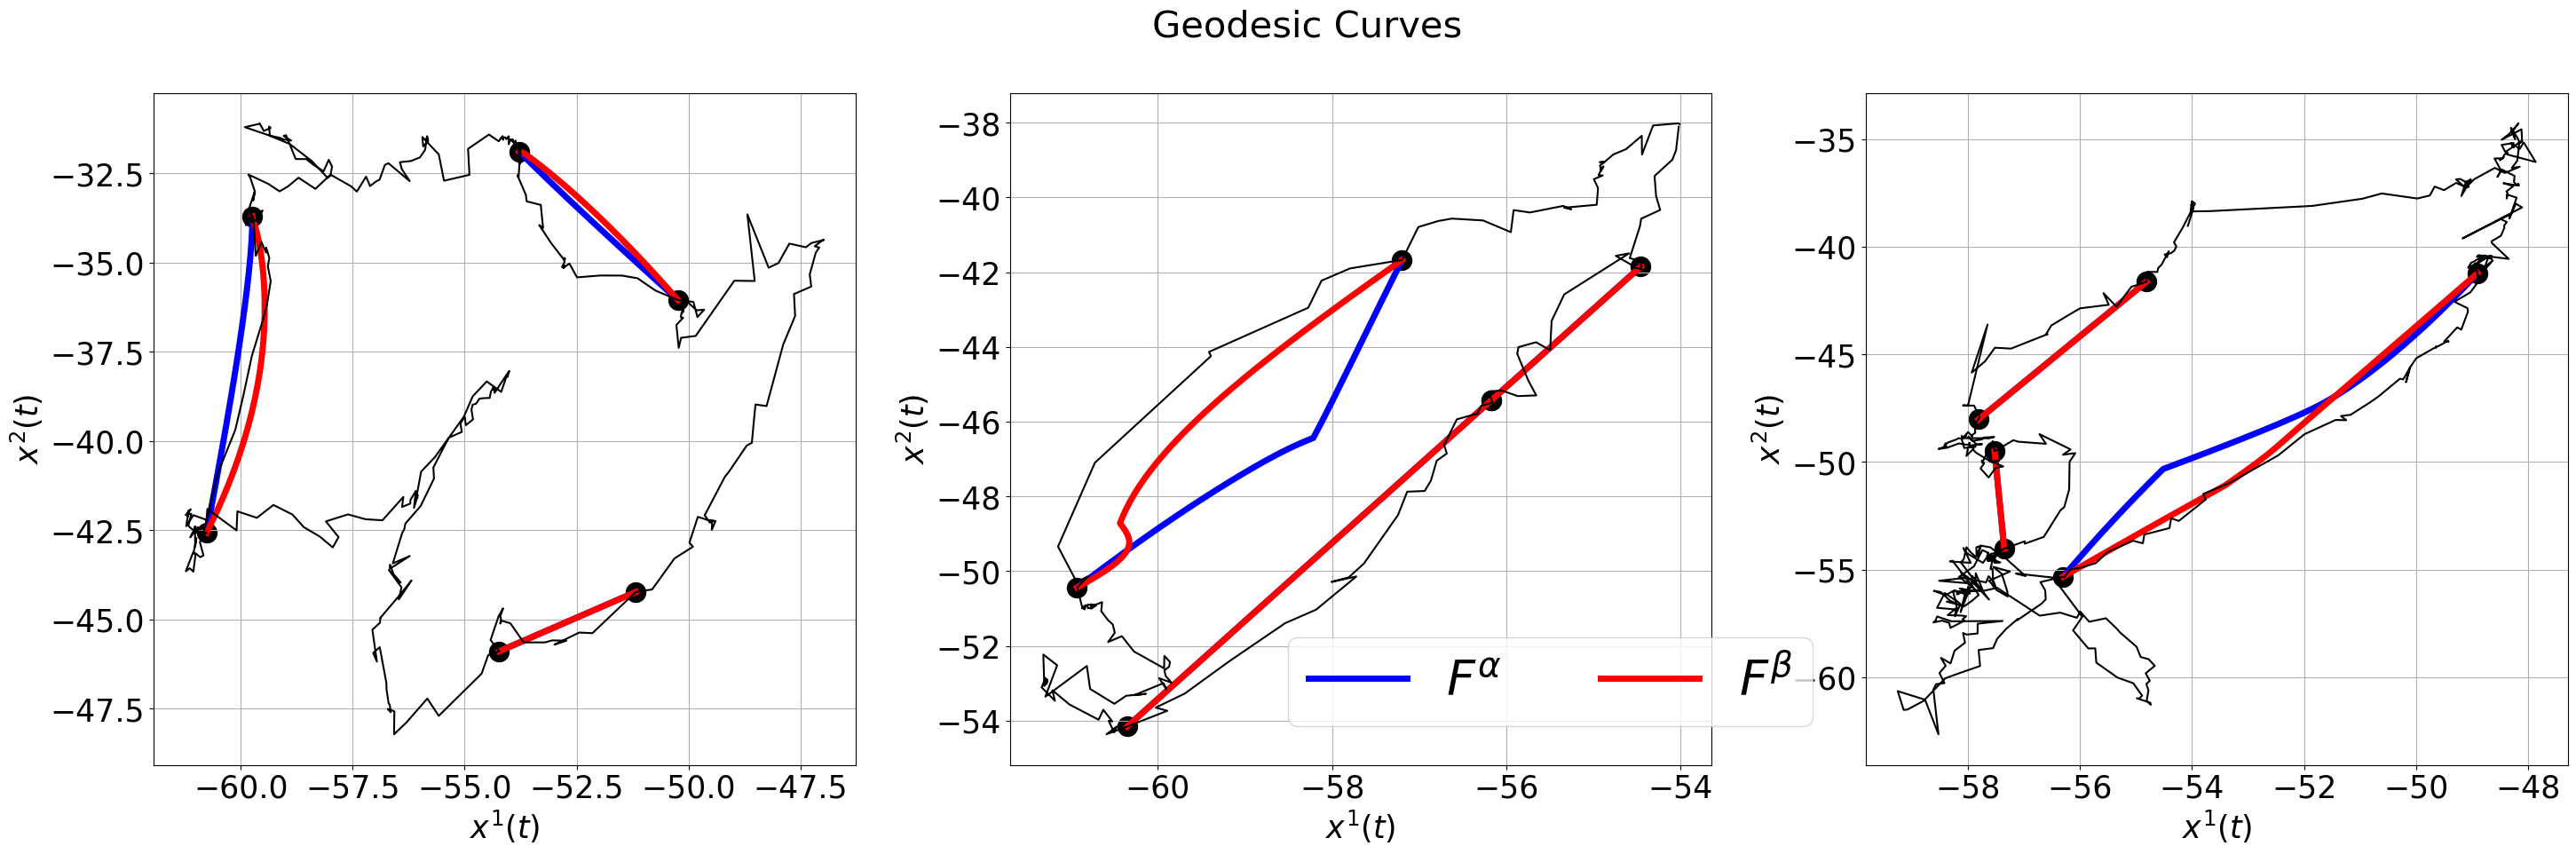

In [30]:
fig = plt.figure(figsize=(len(bird_idx)*10,10))

for i in range(len(bird_idx)):
    ax = fig.add_subplot(1,3,i+1)
    ax.plot(energy_curves[bird_idx[i]]['geodesic_curves'][0][:,0], energy_curves[bird_idx[i]]['geodesic_curves'][0][:,1], 
            color='blue', linewidth=5.)
    ax.scatter(energy_curves[bird_idx[i]]['geodesic_curves'][0][0,0], energy_curves[bird_idx[i]]['geodesic_curves'][0][0,1], 
                color='black', s=250)
    ax.scatter(energy_curves[bird_idx[i]]['geodesic_curves'][0][-1,0], energy_curves[bird_idx[i]]['geodesic_curves'][0][-1,1], 
                color='black', s=250)
    
    ax.plot(energy_curves[bird_idx[i]]['geodesic_curves'][1][:,0], energy_curves[bird_idx[i]]['geodesic_curves'][1][:,1], 
            color='blue', linewidth=5.)
    ax.scatter(energy_curves[bird_idx[i]]['geodesic_curves'][1][0,0], energy_curves[bird_idx[i]]['geodesic_curves'][1][0,1], 
            color='black', s=250)
    ax.scatter(energy_curves[bird_idx[i]]['geodesic_curves'][1][-1,0], energy_curves[bird_idx[i]]['geodesic_curves'][1][-1,1], 
            color='black', s=250)
    
    
    ax.plot(energy_curves[bird_idx[i]]['geodesic_curves'][2][:,0], energy_curves[bird_idx[i]]['geodesic_curves'][2][:,1], 
            color='blue', linewidth=5.)
    ax.scatter(energy_curves[bird_idx[i]]['geodesic_curves'][2][0,0], energy_curves[bird_idx[i]]['geodesic_curves'][2][0,1], 
                color='black', s=250)
    ax.scatter(energy_curves[bird_idx[i]]['geodesic_curves'][2][-1,0], energy_curves[bird_idx[i]]['geodesic_curves'][2][-1,1], 
                color='black', s=250)

    ax.plot(energy_curves[bird_idx[i]]['reverse_geodesic_curves'][0][:,0], energy_curves[bird_idx[i]]['reverse_geodesic_curves'][0][:,1],
            color='red', linewidth=5.)
    ax.plot(energy_curves[bird_idx[i]]['reverse_geodesic_curves'][1][:,0], energy_curves[bird_idx[i]]['reverse_geodesic_curves'][1][:,1],
           color='red', linewidth=5.)
    ax.plot(energy_curves[bird_idx[i]]['reverse_geodesic_curves'][2][:,0], energy_curves[bird_idx[i]]['reverse_geodesic_curves'][2][:,1],
           color='red', linewidth=5.)

    ax.plot(x_data[bird_idx[i]][:,0], x_data[bird_idx[i]][:,1], 'black')
    
    ax.set_xlabel(f'$x^{1}(t)$')
    ax.set_ylabel(f'$x^{2}(t)$')
    ax.grid(True)
    
plt.suptitle("Geodesic Curves")

ax.plot([],[], color="blue", label=r'$F^{\alpha}$', linewidth=5.0)
ax.plot([],[], color="red", label=r'$F^{\beta}$', linewidth=5.0)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.50,0.15), ncol=2, fontsize=40)
    
fig.tight_layout()

fig.savefig(os.path.join(figure_path, 'albatross_geodesic_fixed.pdf'), format='pdf', pad_inches=0.1, bbox_inches='tight')

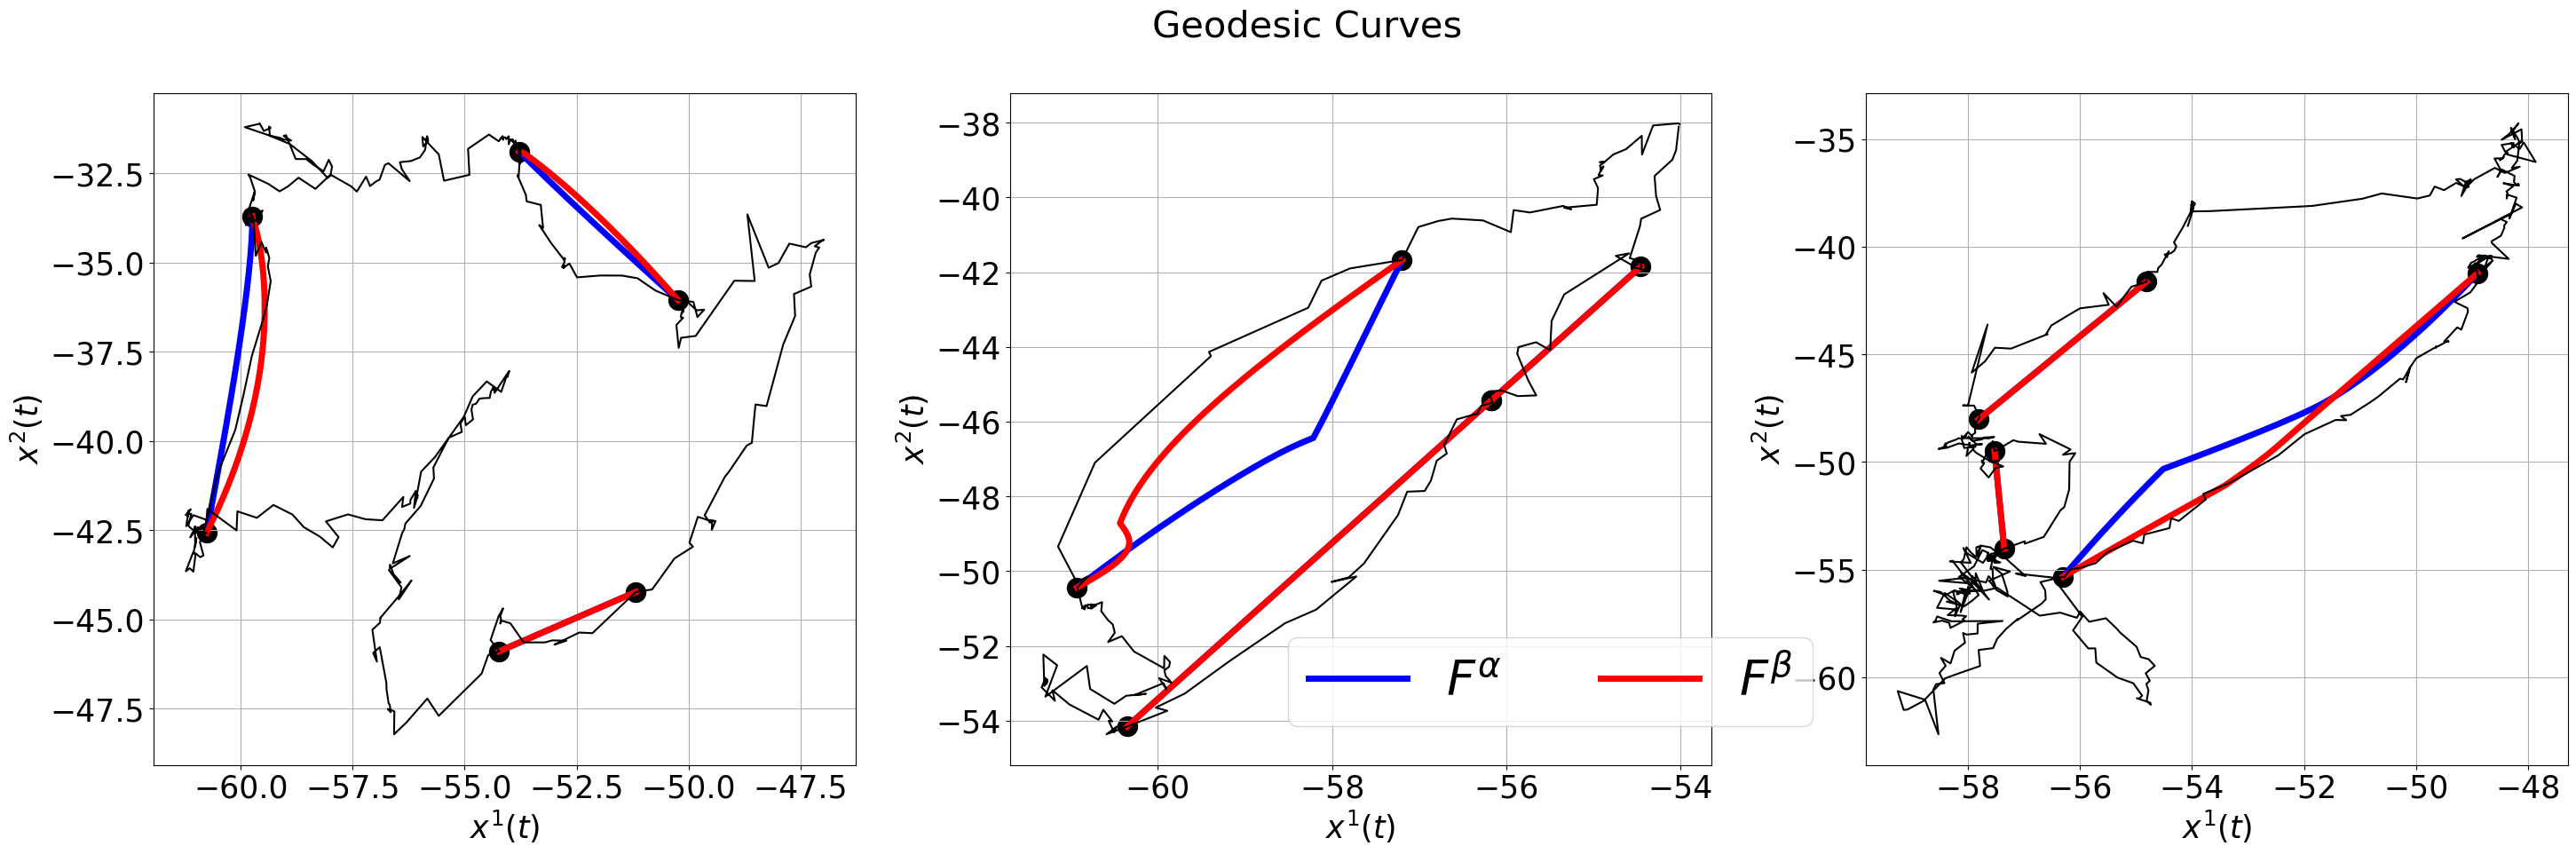

In [31]:
fig = plt.figure(figsize=(len(bird_idx)*10,10))

for i in range(len(bird_idx)):
    ax = fig.add_subplot(1,3,i+1)
    ax.plot(energy_curves[bird_idx[i]]['geodesic_curves'][0][:,0], energy_curves[bird_idx[i]]['geodesic_curves'][0][:,1], 
            color='blue', linewidth=5.)
    ax.scatter(energy_curves[bird_idx[i]]['geodesic_curves'][0][0,0], energy_curves[bird_idx[i]]['geodesic_curves'][0][0,1], 
                color='black', s=250)
    ax.scatter(energy_curves[bird_idx[i]]['geodesic_curves'][0][-1,0], energy_curves[bird_idx[i]]['geodesic_curves'][0][-1,1], 
                color='black', s=250)
    
    ax.plot(energy_curves[bird_idx[i]]['geodesic_curves'][1][:,0], energy_curves[bird_idx[i]]['geodesic_curves'][1][:,1], 
            color='blue', linewidth=5.)
    ax.scatter(energy_curves[bird_idx[i]]['geodesic_curves'][1][0,0], energy_curves[bird_idx[i]]['geodesic_curves'][1][0,1], 
            color='black', s=250)
    ax.scatter(energy_curves[bird_idx[i]]['geodesic_curves'][1][-1,0], energy_curves[bird_idx[i]]['geodesic_curves'][1][-1,1], 
            color='black', s=250)
    
    
    ax.plot(energy_curves[bird_idx[i]]['geodesic_curves'][2][:,0], energy_curves[bird_idx[i]]['geodesic_curves'][2][:,1], 
            color='blue', linewidth=5.)
    ax.scatter(energy_curves[bird_idx[i]]['geodesic_curves'][2][0,0], energy_curves[bird_idx[i]]['geodesic_curves'][2][0,1], 
                color='black', s=250)
    ax.scatter(energy_curves[bird_idx[i]]['geodesic_curves'][2][-1,0], energy_curves[bird_idx[i]]['geodesic_curves'][2][-1,1], 
                color='black', s=250)

    ax.plot(energy_curves[bird_idx[i]]['reverse_geodesic_curves'][0][:,0], energy_curves[bird_idx[i]]['reverse_geodesic_curves'][0][:,1],
            color='red', linewidth=5.)
    ax.plot(energy_curves[bird_idx[i]]['reverse_geodesic_curves'][1][:,0], energy_curves[bird_idx[i]]['reverse_geodesic_curves'][1][:,1],
           color='red', linewidth=5.)
    ax.plot(energy_curves[bird_idx[i]]['reverse_geodesic_curves'][2][:,0], energy_curves[bird_idx[i]]['reverse_geodesic_curves'][2][:,1],
           color='red', linewidth=5.)

    ax.plot(x_data[bird_idx[i]][:,0], x_data[bird_idx[i]][:,1], 'black')
    
    ax.set_xlabel(f'$x^{1}(t)$')
    ax.set_ylabel(f'$x^{2}(t)$')
    ax.grid(True)
    
plt.suptitle("Geodesic Curves")

ax.plot([],[], color="blue", label=r'$F^{\alpha}$', linewidth=5.0)
ax.plot([],[], color="red", label=r'$F^{\beta}$', linewidth=5.0)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.50,0.15), ncol=2, fontsize=40)
    
fig.tight_layout()

fig.savefig(os.path.join(figure_path, 'albatross_geodesic_fixed.pdf'), format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()

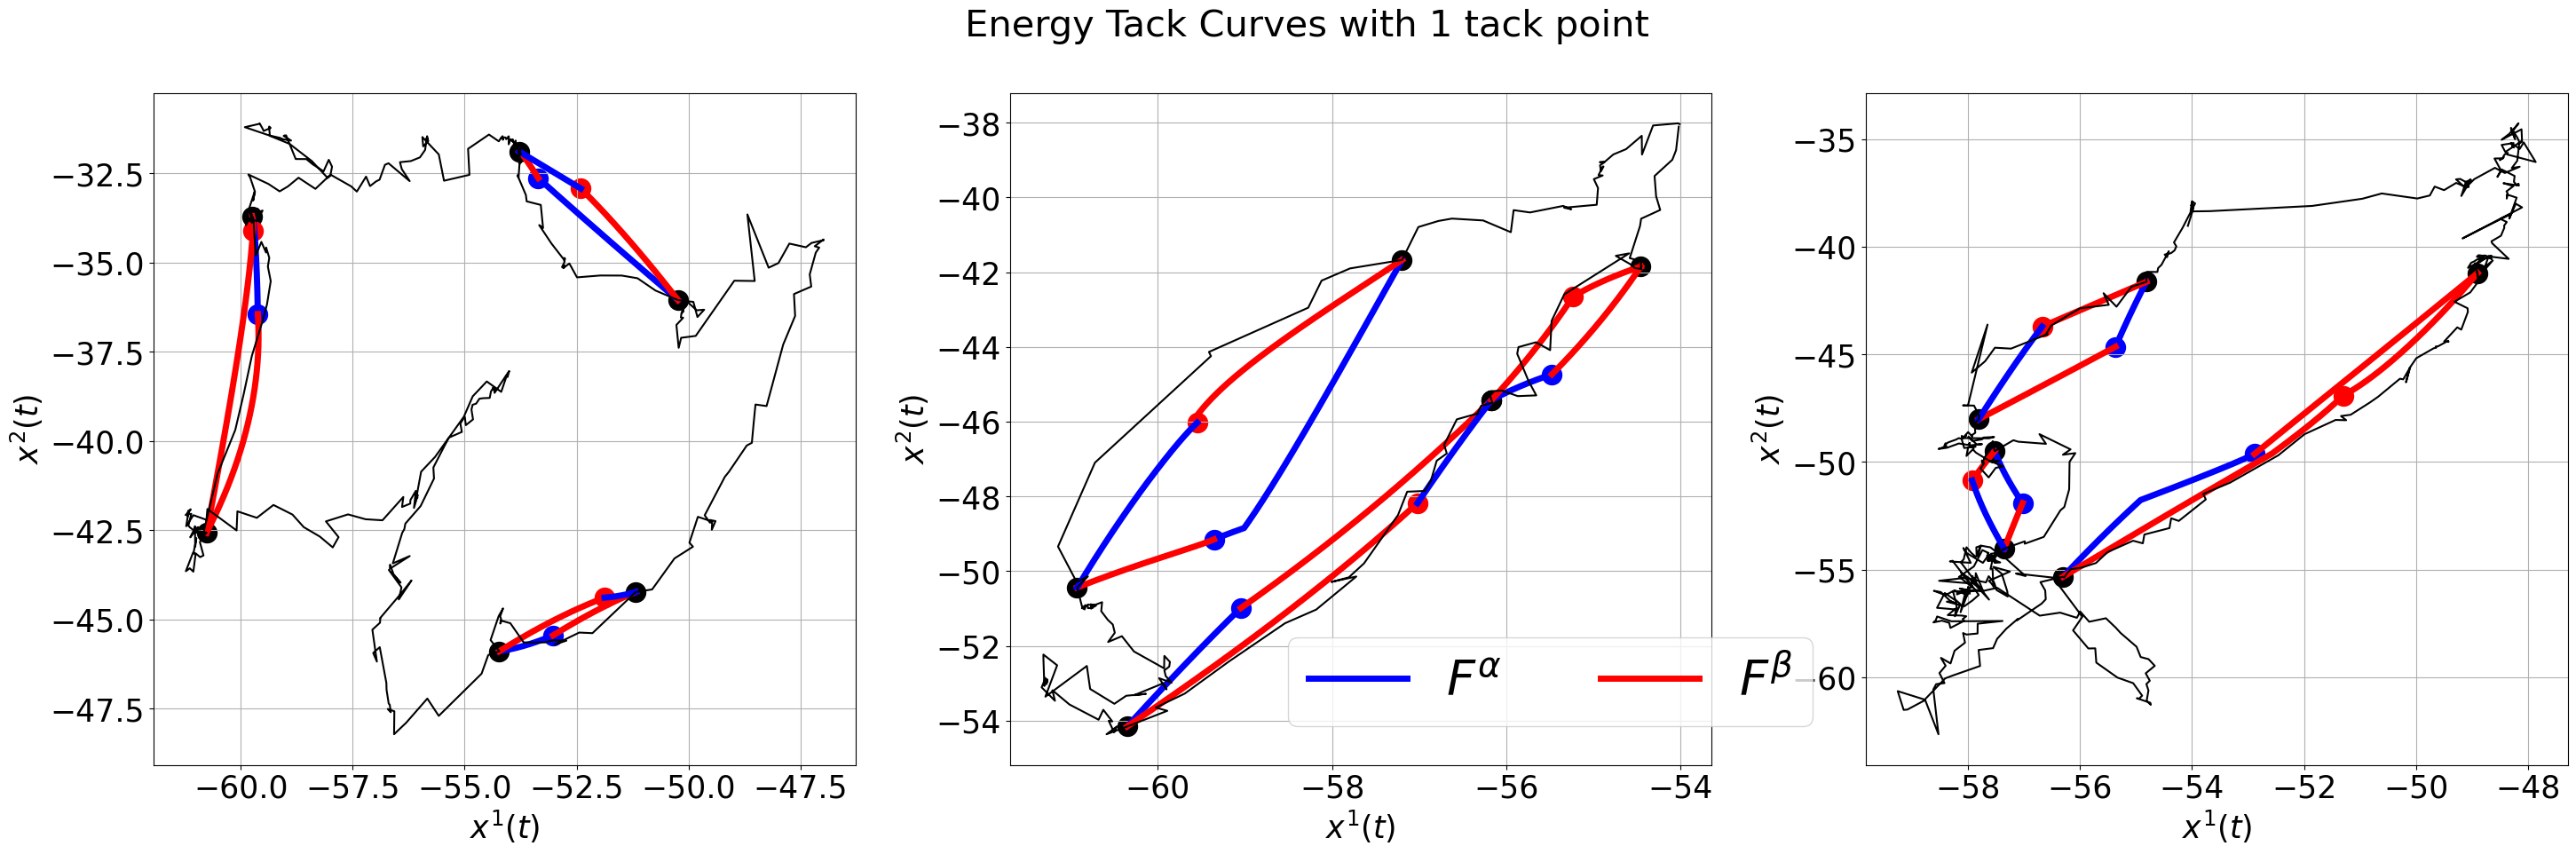

In [32]:
fig = plt.figure(figsize=(len(bird_idx)*10,10))

for i in range(len(bird_idx)):
    ax = fig.add_subplot(1,3,i+1)
    ax.plot(energy_curves[bird_idx[i]]['tack_curves'][0][:T,0], energy_curves[bird_idx[i]]['tack_curves'][0][:T,1], 
            color='blue', linewidth=5.)
    ax.scatter(energy_curves[bird_idx[i]]['tack_curves'][0][T,0], energy_curves[bird_idx[i]]['tack_curves'][0][T,1], 
            color='blue', s=250.)
    ax.plot(energy_curves[bird_idx[i]]['tack_curves'][0][T:,0], energy_curves[bird_idx[i]]['tack_curves'][0][T:,1], 
            color='red', linewidth=5.)
    ax.scatter(energy_curves[bird_idx[i]]['tack_curves'][0][0,0], energy_curves[bird_idx[i]]['tack_curves'][0][0,1], 
                color='black', s=250)
    ax.scatter(energy_curves[bird_idx[i]]['tack_curves'][0][-1,0], energy_curves[bird_idx[i]]['tack_curves'][0][-1,1], 
                color='black', s=250)
    
    ax.plot(energy_curves[bird_idx[i]]['tack_curves'][1][:T,0], energy_curves[bird_idx[i]]['tack_curves'][1][:T,1], 
            color='blue', linewidth=5.)
    ax.scatter(energy_curves[bird_idx[i]]['tack_curves'][1][T,0], energy_curves[bird_idx[i]]['tack_curves'][1][T,1], 
            color='blue', s=250.)
    ax.plot(energy_curves[bird_idx[i]]['tack_curves'][1][T:,0], energy_curves[bird_idx[i]]['tack_curves'][1][T:,1], 
            color='red', linewidth=5.)
    ax.scatter(energy_curves[bird_idx[i]]['tack_curves'][1][0,0], energy_curves[bird_idx[i]]['tack_curves'][1][0,1], 
            color='black', s=250)
    ax.scatter(energy_curves[bird_idx[i]]['tack_curves'][1][-1,0], energy_curves[bird_idx[i]]['tack_curves'][1][-1,1], 
            color='black', s=250)
    
    
    ax.plot(energy_curves[bird_idx[i]]['tack_curves'][2][:T,0], energy_curves[bird_idx[i]]['tack_curves'][2][:T,1], 
            color='blue', linewidth=5.)
    ax.scatter(energy_curves[bird_idx[i]]['tack_curves'][2][T,0], energy_curves[bird_idx[i]]['tack_curves'][2][T,1], 
            color='blue', s=250.)
    ax.plot(energy_curves[bird_idx[i]]['tack_curves'][2][T:,0], energy_curves[bird_idx[i]]['tack_curves'][2][T:,1], 
            color='red', linewidth=5.)
    ax.scatter(energy_curves[bird_idx[i]]['tack_curves'][2][0,0], energy_curves[bird_idx[i]]['tack_curves'][2][0,1], 
                color='black', s=250)
    ax.scatter(energy_curves[bird_idx[i]]['tack_curves'][2][-1,0], energy_curves[bird_idx[i]]['tack_curves'][2][-1,1], 
                color='black', s=250)

    ax.plot(energy_curves[bird_idx[i]]['reverse_tack_curves'][0][:T,0], energy_curves[bird_idx[i]]['reverse_tack_curves'][0][:T,1],
            color='red', linewidth=5.)
    ax.scatter(energy_curves[bird_idx[i]]['reverse_tack_curves'][0][T,0], energy_curves[bird_idx[i]]['reverse_tack_curves'][0][T,1],
            color='red', s=250.)
    ax.plot(energy_curves[bird_idx[i]]['reverse_tack_curves'][0][T:,0], energy_curves[bird_idx[i]]['reverse_tack_curves'][0][T:,1],
            color='blue', linewidth=5.)
    
    ax.plot(energy_curves[bird_idx[i]]['reverse_tack_curves'][1][:T,0], energy_curves[bird_idx[i]]['reverse_tack_curves'][1][:T,1],
           color='red', linewidth=5.)
    ax.scatter(energy_curves[bird_idx[i]]['reverse_tack_curves'][1][T,0], energy_curves[bird_idx[i]]['reverse_tack_curves'][1][T,1],
           color='red', s=250.)
    ax.plot(energy_curves[bird_idx[i]]['reverse_tack_curves'][1][T:,0], energy_curves[bird_idx[i]]['reverse_tack_curves'][1][T:,1],
           color='blue', linewidth=5.)
    
    ax.plot(energy_curves[bird_idx[i]]['reverse_tack_curves'][2][:T,0], energy_curves[bird_idx[i]]['reverse_tack_curves'][2][:T,1],
           color='red', linewidth=5.)
    ax.scatter(energy_curves[bird_idx[i]]['reverse_tack_curves'][2][T,0], energy_curves[bird_idx[i]]['reverse_tack_curves'][2][T,1],
           color='red', s=250.)
    ax.plot(energy_curves[bird_idx[i]]['reverse_tack_curves'][2][T:,0], energy_curves[bird_idx[i]]['reverse_tack_curves'][2][T:,1],
           color='red', linewidth=5.)

    ax.plot(x_data[bird_idx[i]][:,0], x_data[bird_idx[i]][:,1], 'black')
    
    ax.set_xlabel(f'$x^{1}(t)$')
    ax.set_ylabel(f'$x^{2}(t)$')
    ax.grid(True)
    
plt.suptitle("Energy Tack Curves with 1 tack point")

ax.plot([],[], color="blue", label=r'$F^{\alpha}$', linewidth=5.0)
ax.plot([],[], color="red", label=r'$F^{\beta}$', linewidth=5.0)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.50,0.15), ncol=2, fontsize=40)
    
fig.tight_layout()

fig.savefig(os.path.join(figure_path, 'albatross_energy_tack_fixed.pdf'), format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()
    

#### Estimating Time Tack Curves

In [33]:
time_curves = {}
for keys, val in data_idx.items():
    tack_curves = []
    reverse_tack_curves = []
    geodesic_curves = []
    reverse_geodesic_curves = []
    for l in val:
        
        t0 = jnp.zeros(1, dtype=jnp.float64).squeeze()
        z0 = x_data[keys][l[0]]
        zT = x_data[keys][l[1]]
        
        t_val = jnp.hstack((time_data[keys][l[0]], time_data[keys][l[1]]))
        w_val = jnp.vstack((w_data[keys][l[0]], w_data[keys][l[1]]))

        Falpha = LeftMetric(t=t_val, w=w_val)
        Malpha = LorentzFinslerManifold(F=Falpha)

        Fbeta = RightMetric(t=t_val, w=w_val)
        Mbeta = LorentzFinslerManifold(F=Fbeta)
        
        tack_metrics = [Malpha, Mbeta]
        reverse_tack_metrics = [Mbeta, Malpha]
        
        Geodesic = GEORCE_H(Malpha, init_fun=None, T=T, tol=tol, max_iter=max_iter, line_search_params={'rho': 0.5})
        ReverseGeodesic = GEORCE_H(Mbeta, init_fun=None, T=T, tol=tol, max_iter=max_iter, line_search_params={'rho': 0.5})
        
        Tacking = SequentialOptimizationADAM(tack_metrics, init_fun=None, max_iter=1000, 
                                     tol=tol, T=T, sub_iter=0, line_search_params={'rho': 0.5})
        ReverseTacking = SequentialOptimizationADAM(reverse_tack_metrics, init_fun = None, max_iter=1000, tol=tol,
                                                    T=T, sub_iter=0, line_search_params={'rho': 0.5})
        
        print(f"Computing geodesics...")
        zt1 = Geodesic(t0, z0, zT)
        zt2 = ReverseGeodesic(t0, z0, zT)
        print(f"\t -Tavel time for geodesic curve: {zt1[0][-1]:.4f}")
        print(f"\t -Tavel time for reverse geodesic curve: {zt2[0][-1]:.4f}")
        print(f"\t -Idx for geodesic curve: {zt1[-1]}")
        print(f"\t -Idx for reverse geodesic curve: {zt2[-1]}")
        print(f"\t -Grad for geodesic curve: {jnp.linalg.norm(zt1[-2]):.4f}")
        print(f"\t -Grad for reverse geodesic curve: {jnp.linalg.norm(zt2[-2]):.4f}")
        geodesic_curves.append(zt1[1])
        reverse_geodesic_curves.append(zt2[1])
        
        zt1 = Tacking(t0, z0, zT, n_tacks=1)
        zt2 = ReverseTacking(t0, z0, zT, n_tacks=1)
        print(f"\t -Tavel time for tack curve: {zt1[0][-1]:.4f}")
        print(f"\t -Tavel time for reverse tack curve: {zt2[0][-1]:.4f}")
        print(f"\t -Idx for tack curve: {zt1[-1]}")
        print(f"\t -Idx for reverse tack curve: {zt2[-1]}")
        print(f"\t -Grad for tack curve: {jnp.linalg.norm(zt1[-2]):.4f}")
        print(f"\t -Grad for reverse tack curve: {jnp.linalg.norm(zt2[-2]):.4f}")
        
        tack_curves.append(zt1[1])
        reverse_tack_curves.append(zt2[1])
    
    time_curves[keys] = {'tack_curves': tack_curves,
                        'reverse_tack_curves': reverse_tack_curves,
                        'geodesic_curves': geodesic_curves,
                        'reverse_geodesic_curves': reverse_geodesic_curves,
                        }
        

Computing geodesics...
	 -Tavel time for geodesic curve: 0.9689
	 -Tavel time for reverse geodesic curve: 0.6183
	 -Idx for geodesic curve: 0
	 -Idx for reverse geodesic curve: 0
	 -Grad for geodesic curve: 0.0000
	 -Grad for reverse geodesic curve: 0.0000
	 -Tavel time for tack curve: 0.6184
	 -Tavel time for reverse tack curve: 0.6184
	 -Idx for tack curve: 1000
	 -Idx for reverse tack curve: 1000
	 -Grad for tack curve: 0.1530
	 -Grad for reverse tack curve: 0.2035
Computing geodesics...
	 -Tavel time for geodesic curve: 0.8782
	 -Tavel time for reverse geodesic curve: 1.1873
	 -Idx for geodesic curve: 1
	 -Idx for reverse geodesic curve: 1
	 -Grad for geodesic curve: 0.0000
	 -Grad for reverse geodesic curve: 0.0000
	 -Tavel time for tack curve: 0.8799
	 -Tavel time for reverse tack curve: 0.8794
	 -Idx for tack curve: 1000
	 -Idx for reverse tack curve: 1000
	 -Grad for tack curve: 0.0307
	 -Grad for reverse tack curve: 0.0335
Computing geodesics...
	 -Tavel time for geodesic curv

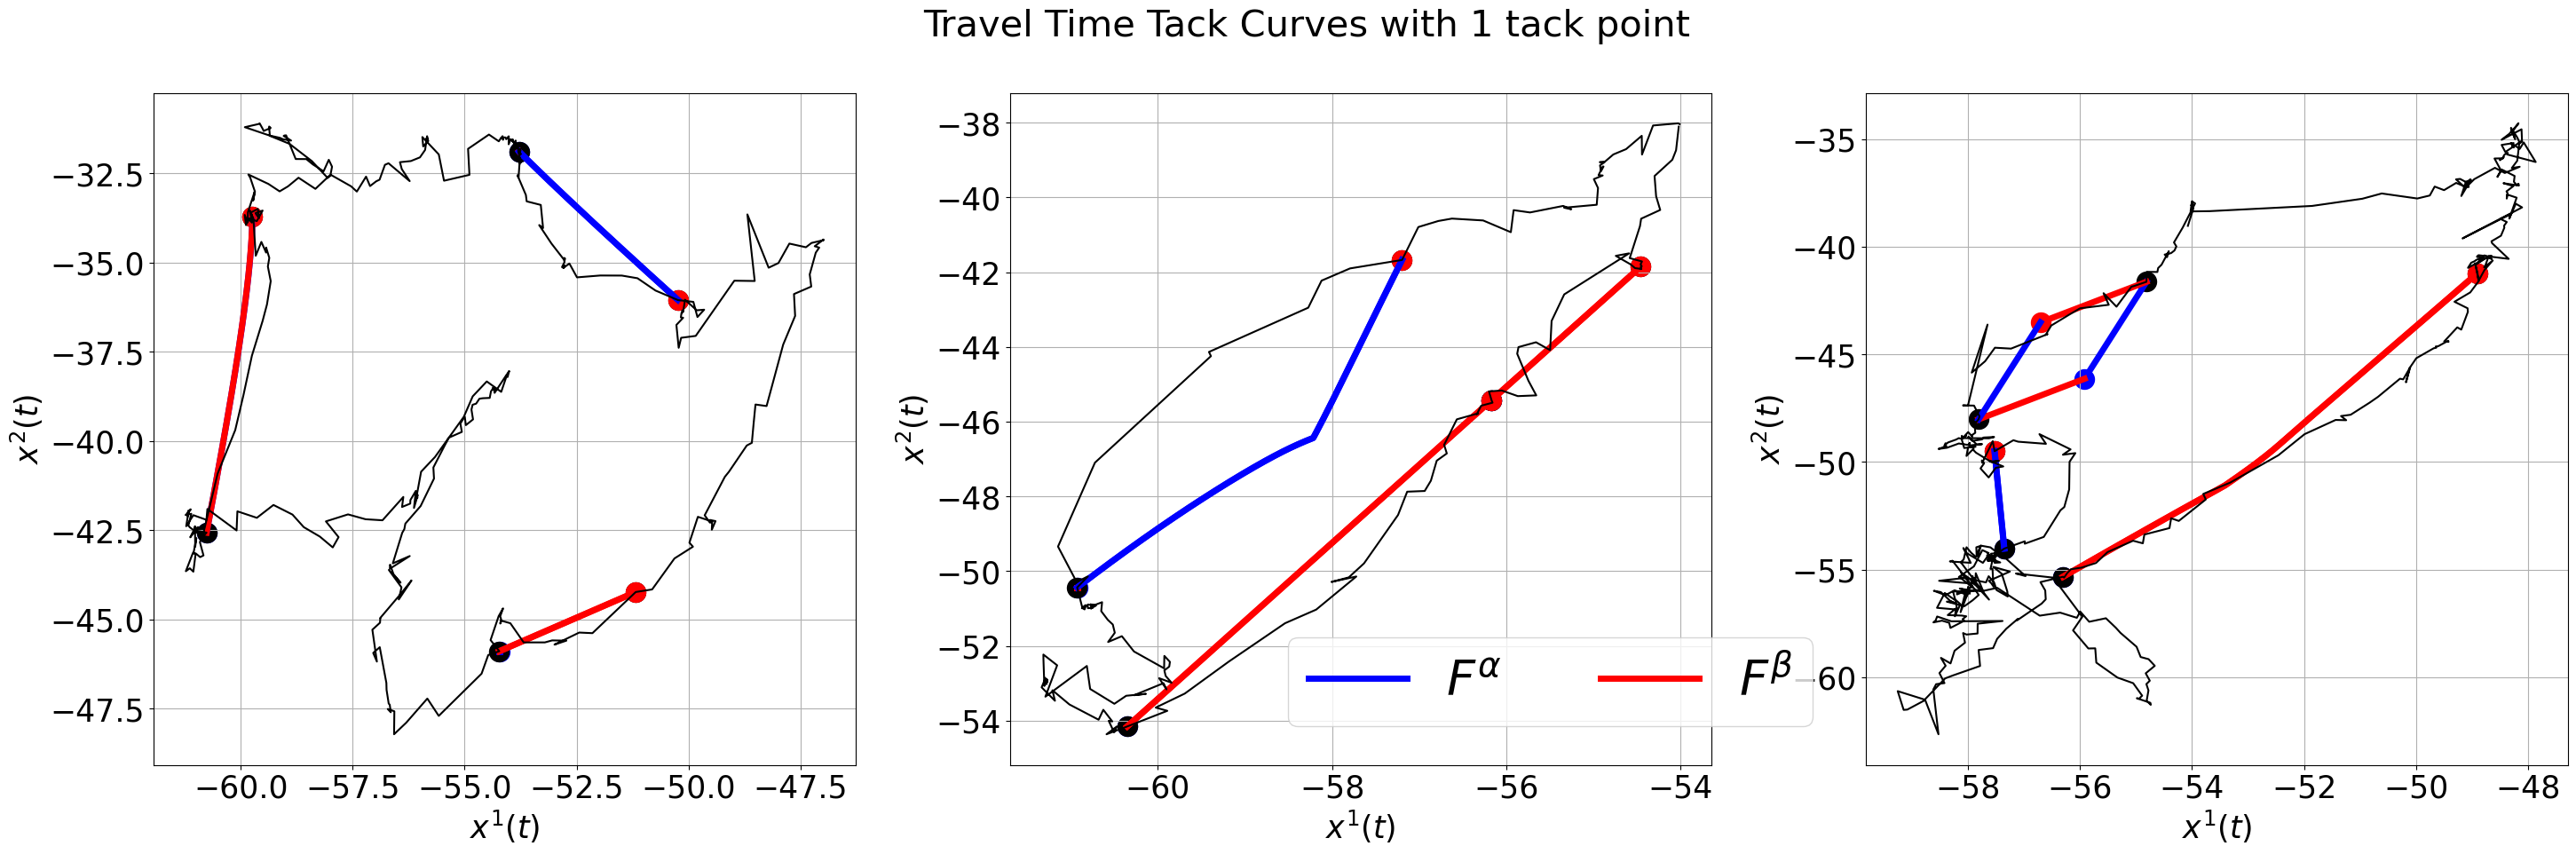

In [34]:
fig = plt.figure(figsize=(len(bird_idx)*10,10))

for i in range(len(bird_idx)):
    ax = fig.add_subplot(1,3,i+1)
    ax.plot(time_curves[bird_idx[i]]['tack_curves'][0][:T,0], time_curves[bird_idx[i]]['tack_curves'][0][:T,1], 
            color='blue', linewidth=5.)
    ax.scatter(time_curves[bird_idx[i]]['tack_curves'][0][T,0], time_curves[bird_idx[i]]['tack_curves'][0][T,1], 
            color='blue', s=250.)
    ax.plot(time_curves[bird_idx[i]]['tack_curves'][0][T:,0], time_curves[bird_idx[i]]['tack_curves'][0][T:,1], 
            color='red', linewidth=5.)
    ax.scatter(time_curves[bird_idx[i]]['tack_curves'][0][0,0], time_curves[bird_idx[i]]['tack_curves'][0][0,1], 
                color='black', s=250)
    ax.scatter(time_curves[bird_idx[i]]['tack_curves'][0][-1,0], time_curves[bird_idx[i]]['tack_curves'][0][-1,1], 
                color='black', s=250)
    
    ax.plot(time_curves[bird_idx[i]]['tack_curves'][1][:T,0], time_curves[bird_idx[i]]['tack_curves'][1][:T,1], 
            color='blue', linewidth=5.)
    ax.scatter(time_curves[bird_idx[i]]['tack_curves'][1][T,0], time_curves[bird_idx[i]]['tack_curves'][1][T,1], 
            color='blue', s=250.)
    ax.plot(time_curves[bird_idx[i]]['tack_curves'][1][T:,0], time_curves[bird_idx[i]]['tack_curves'][1][T:,1], 
            color='red', linewidth=5.)
    ax.scatter(time_curves[bird_idx[i]]['tack_curves'][1][0,0], time_curves[bird_idx[i]]['tack_curves'][1][0,1], 
            color='black', s=250)
    ax.scatter(time_curves[bird_idx[i]]['tack_curves'][1][-1,0], time_curves[bird_idx[i]]['tack_curves'][1][-1,1], 
            color='black', s=250)
    
    
    ax.plot(time_curves[bird_idx[i]]['tack_curves'][2][:T,0], time_curves[bird_idx[i]]['tack_curves'][2][:T,1], 
            color='blue', linewidth=5.)
    ax.scatter(time_curves[bird_idx[i]]['tack_curves'][2][T,0], time_curves[bird_idx[i]]['tack_curves'][2][T,1], 
            color='blue', s=250.)
    ax.plot(time_curves[bird_idx[i]]['tack_curves'][2][T:,0], time_curves[bird_idx[i]]['tack_curves'][2][T:,1], 
            color='red', linewidth=5.)
    ax.scatter(time_curves[bird_idx[i]]['tack_curves'][2][0,0], time_curves[bird_idx[i]]['tack_curves'][2][0,1], 
                color='black', s=250)
    ax.scatter(time_curves[bird_idx[i]]['tack_curves'][2][-1,0], time_curves[bird_idx[i]]['tack_curves'][2][-1,1], 
                color='black', s=250)

    ax.plot(time_curves[bird_idx[i]]['reverse_tack_curves'][0][:T,0], time_curves[bird_idx[i]]['reverse_tack_curves'][0][:T,1],
            color='red', linewidth=5.)
    ax.scatter(time_curves[bird_idx[i]]['reverse_tack_curves'][0][T,0], time_curves[bird_idx[i]]['reverse_tack_curves'][0][T,1],
            color='red', s=250.)
    ax.plot(time_curves[bird_idx[i]]['reverse_tack_curves'][0][T:,0], time_curves[bird_idx[i]]['reverse_tack_curves'][0][T:,1],
            color='blue', linewidth=5.)
    
    ax.plot(time_curves[bird_idx[i]]['reverse_tack_curves'][1][:T,0], time_curves[bird_idx[i]]['reverse_tack_curves'][1][:T,1],
           color='red', linewidth=5.)
    ax.scatter(time_curves[bird_idx[i]]['reverse_tack_curves'][1][T,0], time_curves[bird_idx[i]]['reverse_tack_curves'][1][T,1],
           color='red', s=250.)
    ax.plot(time_curves[bird_idx[i]]['reverse_tack_curves'][1][T:,0], time_curves[bird_idx[i]]['reverse_tack_curves'][1][T:,1],
           color='blue', linewidth=5.)
    
    ax.plot(time_curves[bird_idx[i]]['reverse_tack_curves'][2][:T,0], time_curves[bird_idx[i]]['reverse_tack_curves'][2][:T,1],
           color='red', linewidth=5.)
    ax.scatter(time_curves[bird_idx[i]]['reverse_tack_curves'][2][T,0], time_curves[bird_idx[i]]['reverse_tack_curves'][2][T,1],
           color='red', s=250.)
    ax.plot(time_curves[bird_idx[i]]['reverse_tack_curves'][2][T:,0], time_curves[bird_idx[i]]['reverse_tack_curves'][2][T:,1],
           color='red', linewidth=5.)

    ax.plot(x_data[bird_idx[i]][:,0], x_data[bird_idx[i]][:,1], 'black')
    
    ax.set_xlabel(f'$x^{1}(t)$')
    ax.set_ylabel(f'$x^{2}(t)$')
    ax.grid(True)
    
plt.suptitle("Travel Time Tack Curves with 1 tack point")

ax.plot([],[], color="blue", label=r'$F^{\alpha}$', linewidth=5.0)
ax.plot([],[], color="red", label=r'$F^{\beta}$', linewidth=5.0)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.50,0.15), ncol=2, fontsize=40)
    
fig.tight_layout()

fig.savefig(os.path.join(figure_path, 'albatross_time_tack_fixed.pdf'), format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()
    

### Estimating Tack Curves with Interpolation for Wind

#### Estimating Energy Tack Curves

In [35]:
energy_curves = {}
for keys, val in data_idx.items():
    tack_curves = []
    reverse_tack_curves = []
    geodesic_curves = []
    reverse_geodesic_curves = []
    for l in val:
        
        t0 = jnp.zeros(1, dtype=jnp.float64).squeeze()
        z0 = x_data[keys][l[0]]
        zT = x_data[keys][l[1]]
        
        t_val = time_data[keys][l[0]:(l[1]+1)]
        w_val = w_data[keys][l[0]:(l[1]+1)]

        Falpha = LeftMetric(t=t_val, w=w_val)
        Malpha = LorentzFinslerManifold(F=Falpha)

        Fbeta = RightMetric(t=t_val, w=w_val)
        Mbeta = LorentzFinslerManifold(F=Fbeta)
        
        tack_metrics = [Malpha, Mbeta]
        reverse_tack_metrics = [Mbeta, Malpha]
        
        Geodesic = GEORCE_H(Malpha, init_fun=None, T=T, tol=tol, max_iter=max_iter, line_search_params={'rho': 0.5})
        ReverseGeodesic = GEORCE_H(Mbeta, init_fun=None, T=T, tol=tol, max_iter=max_iter, line_search_params={'rho': 0.5})
        
        EnergyTacking = GEORCE_HTacking(tack_metrics, init_fun=None, T=T, tol=tol, max_iter=max_iter, line_search_params={'rho': 0.5})
        EnergyReverseTacking = GEORCE_HTacking(reverse_tack_metrics, init_fun=None, T=T, tol=tol, max_iter=max_iter, line_search_params={'rho': 0.5})
        
        print(f"Computing geodesics...")
        zt1 = Geodesic(t0, z0, zT)
        zt2 = ReverseGeodesic(t0, z0, zT)
        print(f"\t -Tavel time for geodesic curve: {zt1[0][-1]:.4f}")
        print(f"\t -Tavel time for reverse geodesic curve: {zt2[0][-1]:.4f}")
        print(f"\t -Idx for geodesic curve: {zt1[-1]}")
        print(f"\t -Idx for reverse geodesic curve: {zt2[-1]}")
        print(f"\t -Grad for geodesic curve: {jnp.linalg.norm(zt1[-2]):.4f}")
        print(f"\t -Grad for reverse geodesic curve: {jnp.linalg.norm(zt2[-2]):.4f}")
        geodesic_curves.append(zt1[1])
        reverse_geodesic_curves.append(zt2[1])
        
        zt1 = EnergyTacking(t0, z0, zT, n_tacks=1)
        zt2 = EnergyReverseTacking(t0, z0, zT, n_tacks=1)
        print(f"\t -Tavel time for tack curve: {zt1[0][-1]:.4f}")
        print(f"\t -Tavel time for reverse tack curve: {zt2[0][-1]:.4f}")
        print(f"\t -Idx for tack curve: {zt1[-1]}")
        print(f"\t -Idx for reverse tack curve: {zt2[-1]}")
        print(f"\t -Grad for tack curve: {jnp.linalg.norm(zt1[-2]):.4f}")
        print(f"\t -Grad for reverse tack curve: {jnp.linalg.norm(zt2[-2]):.4f}")
        
        tack_curves.append(zt1[1])
        reverse_tack_curves.append(zt2[1])
    
    energy_curves[keys] = {'tack_curves': tack_curves,
                            'reverse_tack_curves': reverse_tack_curves,
                            'geodesic_curves': geodesic_curves,
                            'reverse_geodesic_curves': reverse_geodesic_curves,
                            }
        

Computing geodesics...
	 -Tavel time for geodesic curve: 0.7111
	 -Tavel time for reverse geodesic curve: 0.4885
	 -Idx for geodesic curve: 1
	 -Idx for reverse geodesic curve: 1
	 -Grad for geodesic curve: 0.0001
	 -Grad for reverse geodesic curve: 0.0000
	 -Tavel time for tack curve: 0.5812
	 -Tavel time for reverse tack curve: 0.5364
	 -Idx for tack curve: 1
	 -Idx for reverse tack curve: 1
	 -Grad for tack curve: 0.0000
	 -Grad for reverse tack curve: 0.0000
Computing geodesics...
	 -Tavel time for geodesic curve: 1.5838
	 -Tavel time for reverse geodesic curve: 1.1445
	 -Idx for geodesic curve: 1
	 -Idx for reverse geodesic curve: 2
	 -Grad for geodesic curve: 0.0000
	 -Grad for reverse geodesic curve: 0.0000
	 -Tavel time for tack curve: 1.5454
	 -Tavel time for reverse tack curve: 1.1487
	 -Idx for tack curve: 1
	 -Idx for reverse tack curve: 1
	 -Grad for tack curve: 0.0000
	 -Grad for reverse tack curve: 0.0001
Computing geodesics...
	 -Tavel time for geodesic curve: 4.8377
	 

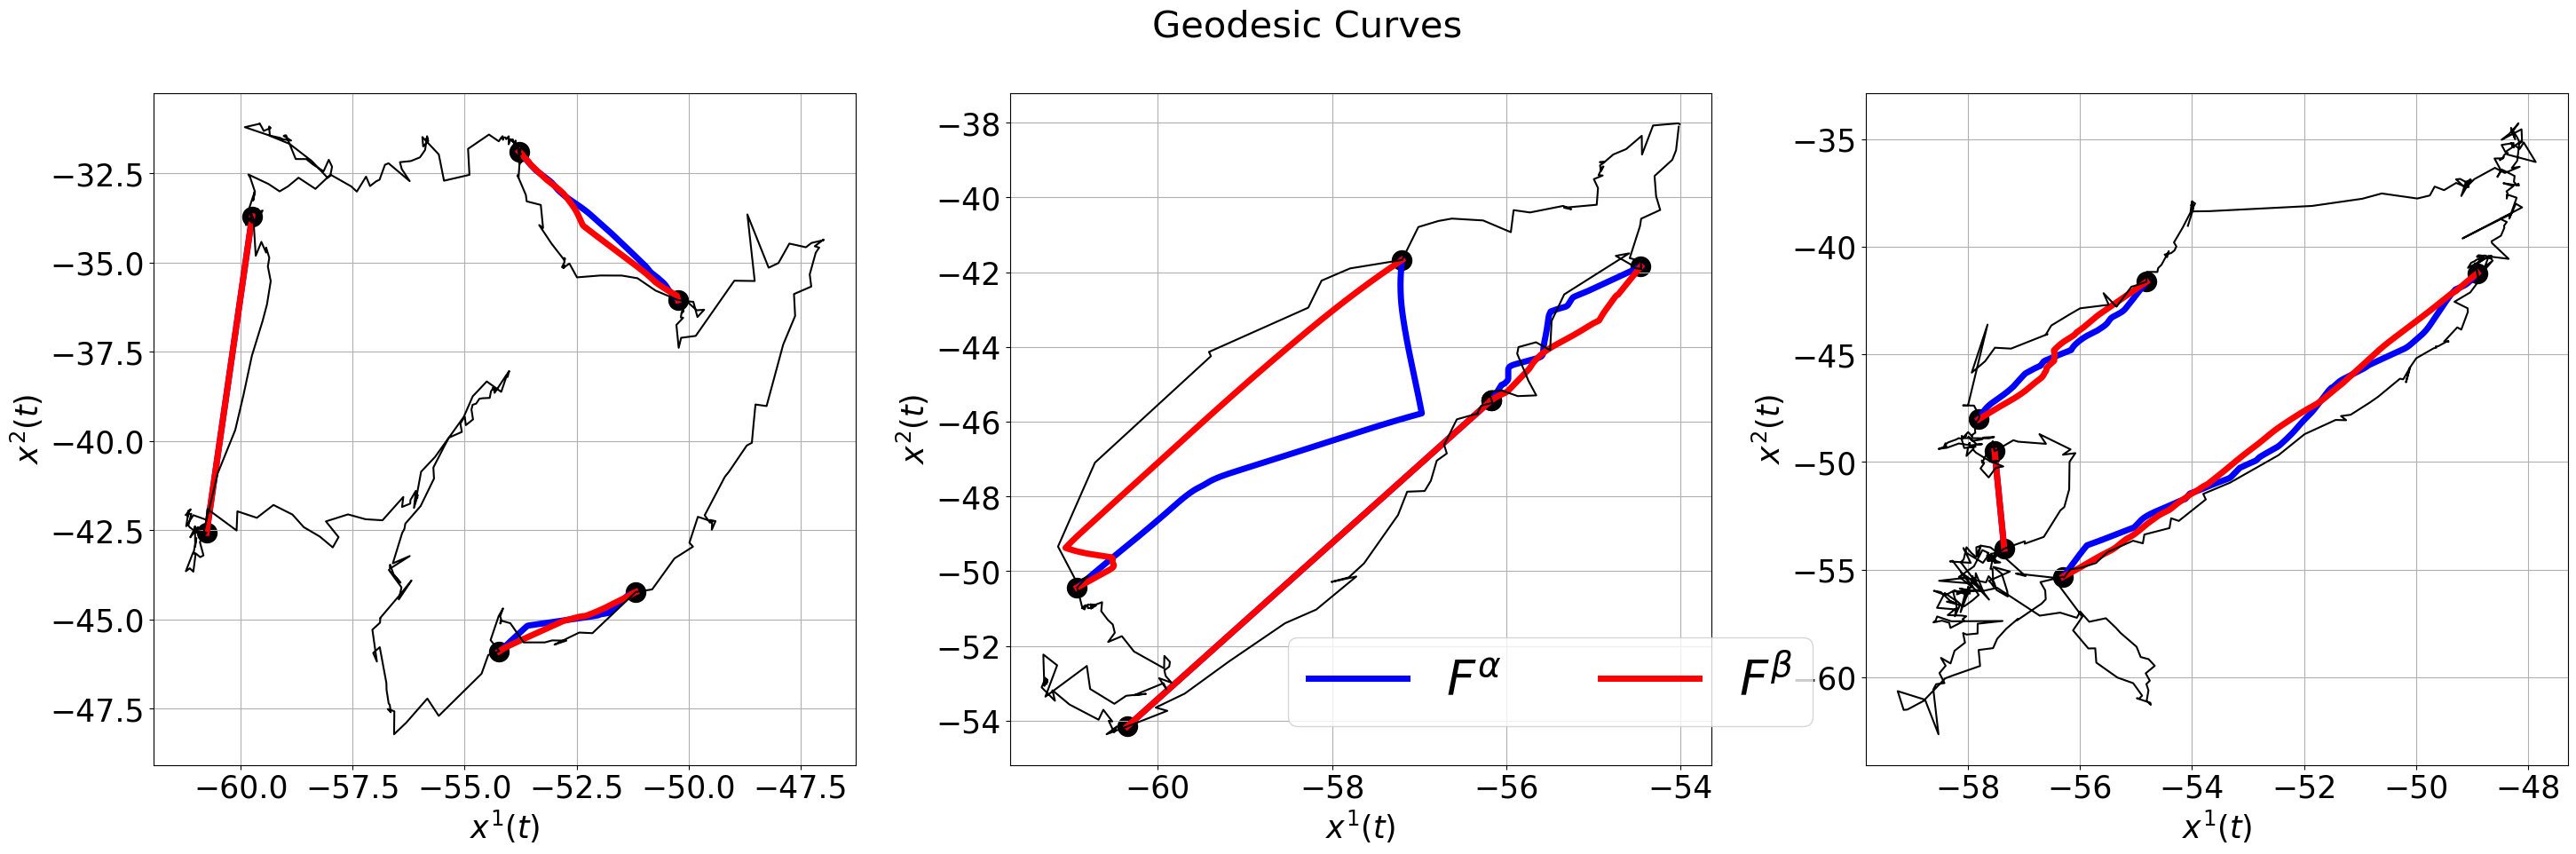

In [36]:
fig = plt.figure(figsize=(len(bird_idx)*10,10))

for i in range(len(bird_idx)):
    ax = fig.add_subplot(1,3,i+1)
    ax.plot(energy_curves[bird_idx[i]]['geodesic_curves'][0][:,0], energy_curves[bird_idx[i]]['geodesic_curves'][0][:,1], 
            color='blue', linewidth=5.)
    ax.scatter(energy_curves[bird_idx[i]]['geodesic_curves'][0][0,0], energy_curves[bird_idx[i]]['geodesic_curves'][0][0,1], 
                color='black', s=250)
    ax.scatter(energy_curves[bird_idx[i]]['geodesic_curves'][0][-1,0], energy_curves[bird_idx[i]]['geodesic_curves'][0][-1,1], 
                color='black', s=250)
    
    ax.plot(energy_curves[bird_idx[i]]['geodesic_curves'][1][:,0], energy_curves[bird_idx[i]]['geodesic_curves'][1][:,1], 
            color='blue', linewidth=5.)
    ax.scatter(energy_curves[bird_idx[i]]['geodesic_curves'][1][0,0], energy_curves[bird_idx[i]]['geodesic_curves'][1][0,1], 
            color='black', s=250)
    ax.scatter(energy_curves[bird_idx[i]]['geodesic_curves'][1][-1,0], energy_curves[bird_idx[i]]['geodesic_curves'][1][-1,1], 
            color='black', s=250)
    
    
    ax.plot(energy_curves[bird_idx[i]]['geodesic_curves'][2][:,0], energy_curves[bird_idx[i]]['geodesic_curves'][2][:,1], 
            color='blue', linewidth=5.)
    ax.scatter(energy_curves[bird_idx[i]]['geodesic_curves'][2][0,0], energy_curves[bird_idx[i]]['geodesic_curves'][2][0,1], 
                color='black', s=250)
    ax.scatter(energy_curves[bird_idx[i]]['geodesic_curves'][2][-1,0], energy_curves[bird_idx[i]]['geodesic_curves'][2][-1,1], 
                color='black', s=250)

    ax.plot(energy_curves[bird_idx[i]]['reverse_geodesic_curves'][0][:,0], energy_curves[bird_idx[i]]['reverse_geodesic_curves'][0][:,1],
            color='red', linewidth=5.)
    ax.plot(energy_curves[bird_idx[i]]['reverse_geodesic_curves'][1][:,0], energy_curves[bird_idx[i]]['reverse_geodesic_curves'][1][:,1],
           color='red', linewidth=5.)
    ax.plot(energy_curves[bird_idx[i]]['reverse_geodesic_curves'][2][:,0], energy_curves[bird_idx[i]]['reverse_geodesic_curves'][2][:,1],
           color='red', linewidth=5.)

    ax.plot(x_data[bird_idx[i]][:,0], x_data[bird_idx[i]][:,1], 'black')
    
    ax.set_xlabel(f'$x^{1}(t)$')
    ax.set_ylabel(f'$x^{2}(t)$')
    ax.grid(True)
    
plt.suptitle("Geodesic Curves")

ax.plot([],[], color="blue", label=r'$F^{\alpha}$', linewidth=5.0)
ax.plot([],[], color="red", label=r'$F^{\beta}$', linewidth=5.0)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.50,0.15), ncol=2, fontsize=40)
    
fig.tight_layout()

fig.savefig(os.path.join(figure_path, 'albatross_geodesic_interp.pdf'), format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()

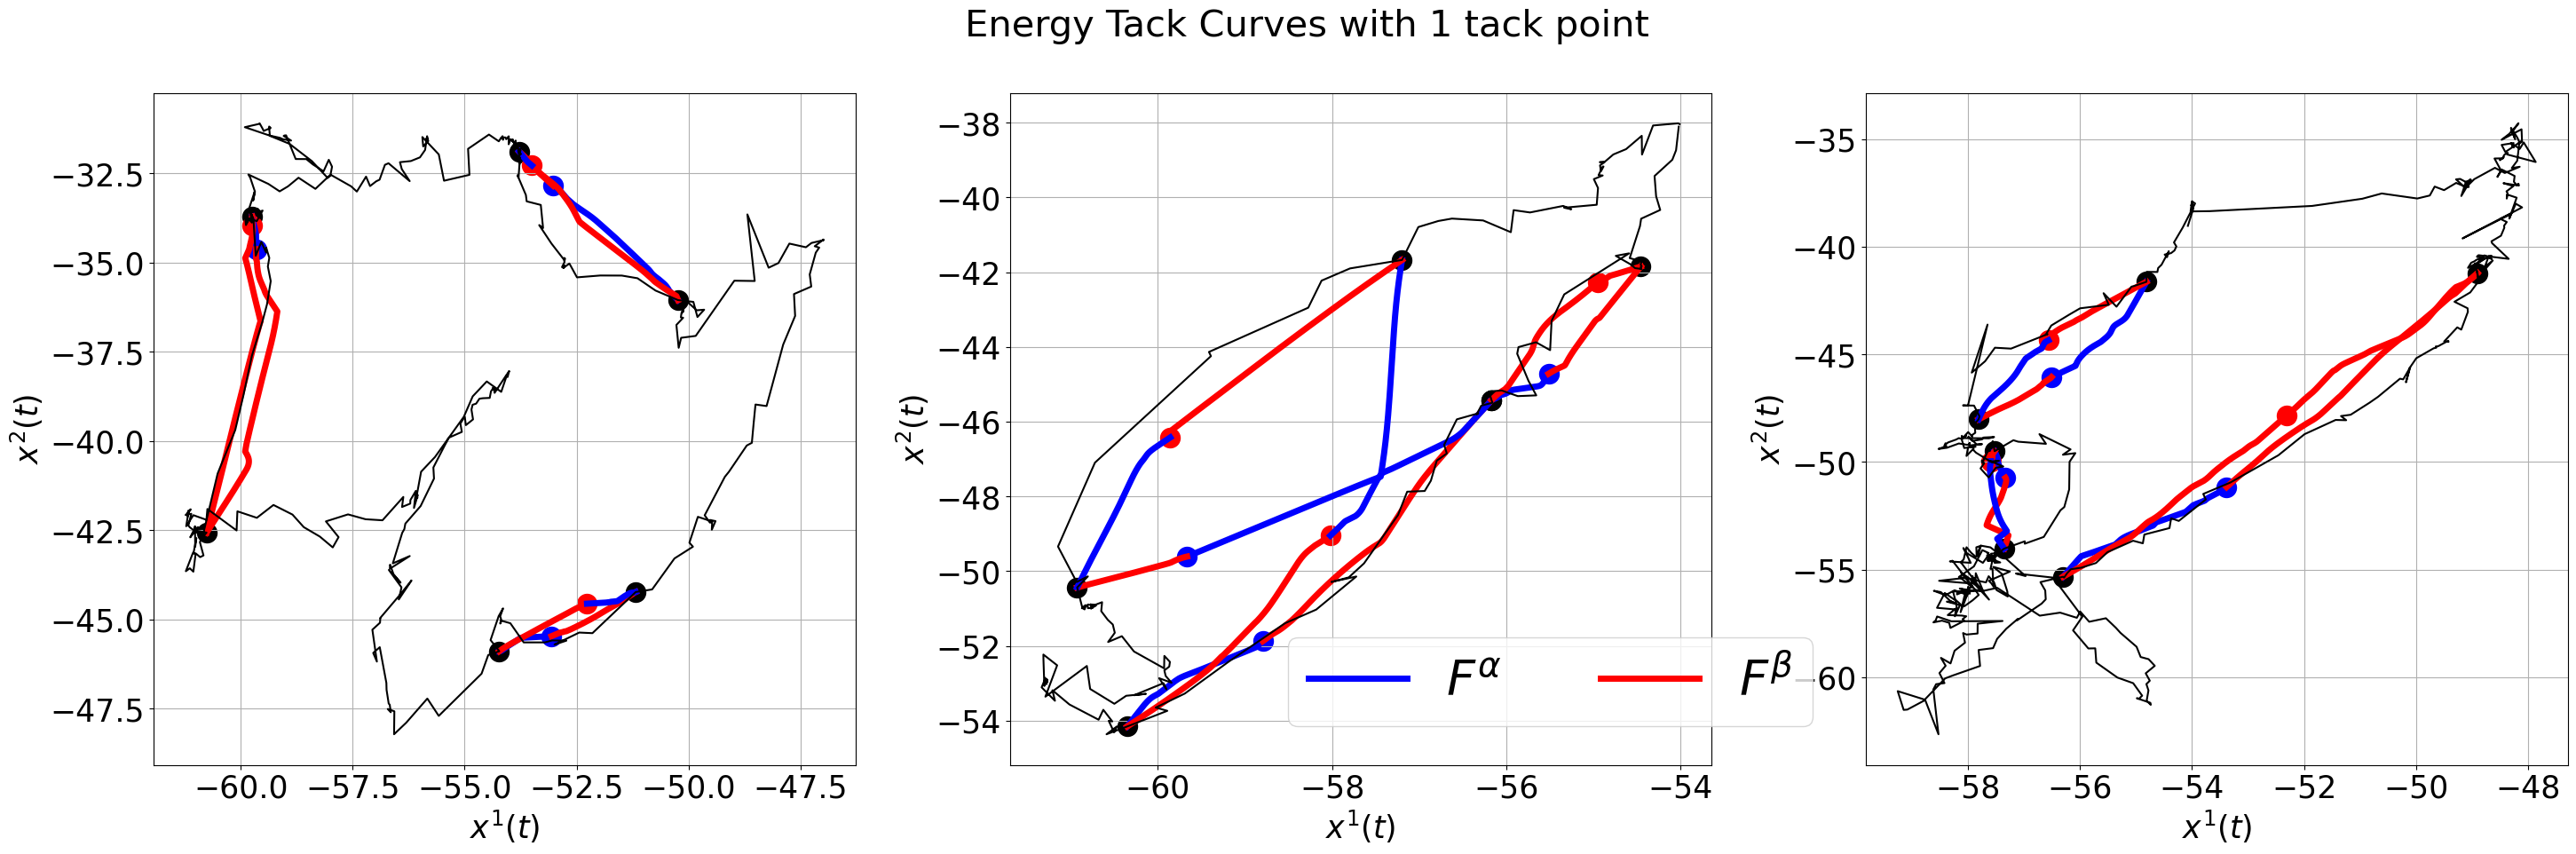

In [37]:
fig = plt.figure(figsize=(len(bird_idx)*10,10))

for i in range(len(bird_idx)):
    ax = fig.add_subplot(1,3,i+1)
    ax.plot(energy_curves[bird_idx[i]]['tack_curves'][0][:T,0], energy_curves[bird_idx[i]]['tack_curves'][0][:T,1], 
            color='blue', linewidth=5.)
    ax.scatter(energy_curves[bird_idx[i]]['tack_curves'][0][T,0], energy_curves[bird_idx[i]]['tack_curves'][0][T,1], 
            color='blue', s=250.)
    ax.plot(energy_curves[bird_idx[i]]['tack_curves'][0][T:,0], energy_curves[bird_idx[i]]['tack_curves'][0][T:,1], 
            color='red', linewidth=5.)
    ax.scatter(energy_curves[bird_idx[i]]['tack_curves'][0][0,0], energy_curves[bird_idx[i]]['tack_curves'][0][0,1], 
                color='black', s=250)
    ax.scatter(energy_curves[bird_idx[i]]['tack_curves'][0][-1,0], energy_curves[bird_idx[i]]['tack_curves'][0][-1,1], 
                color='black', s=250)
    
    ax.plot(energy_curves[bird_idx[i]]['tack_curves'][1][:T,0], energy_curves[bird_idx[i]]['tack_curves'][1][:T,1], 
            color='blue', linewidth=5.)
    ax.scatter(energy_curves[bird_idx[i]]['tack_curves'][1][T,0], energy_curves[bird_idx[i]]['tack_curves'][1][T,1], 
            color='blue', s=250.)
    ax.plot(energy_curves[bird_idx[i]]['tack_curves'][1][T:,0], energy_curves[bird_idx[i]]['tack_curves'][1][T:,1], 
            color='red', linewidth=5.)
    ax.scatter(energy_curves[bird_idx[i]]['tack_curves'][1][0,0], energy_curves[bird_idx[i]]['tack_curves'][1][0,1], 
            color='black', s=250)
    ax.scatter(energy_curves[bird_idx[i]]['tack_curves'][1][-1,0], energy_curves[bird_idx[i]]['tack_curves'][1][-1,1], 
            color='black', s=250)
    
    
    ax.plot(energy_curves[bird_idx[i]]['tack_curves'][2][:T,0], energy_curves[bird_idx[i]]['tack_curves'][2][:T,1], 
            color='blue', linewidth=5.)
    ax.scatter(energy_curves[bird_idx[i]]['tack_curves'][2][T,0], energy_curves[bird_idx[i]]['tack_curves'][2][T,1], 
            color='blue', s=250.)
    ax.plot(energy_curves[bird_idx[i]]['tack_curves'][2][T:,0], energy_curves[bird_idx[i]]['tack_curves'][2][T:,1], 
            color='red', linewidth=5.)
    ax.scatter(energy_curves[bird_idx[i]]['tack_curves'][2][0,0], energy_curves[bird_idx[i]]['tack_curves'][2][0,1], 
                color='black', s=250)
    ax.scatter(energy_curves[bird_idx[i]]['tack_curves'][2][-1,0], energy_curves[bird_idx[i]]['tack_curves'][2][-1,1], 
                color='black', s=250)

    ax.plot(energy_curves[bird_idx[i]]['reverse_tack_curves'][0][:T,0], energy_curves[bird_idx[i]]['reverse_tack_curves'][0][:T,1],
            color='red', linewidth=5.)
    ax.scatter(energy_curves[bird_idx[i]]['reverse_tack_curves'][0][T,0], energy_curves[bird_idx[i]]['reverse_tack_curves'][0][T,1],
            color='red', s=250.)
    ax.plot(energy_curves[bird_idx[i]]['reverse_tack_curves'][0][T:,0], energy_curves[bird_idx[i]]['reverse_tack_curves'][0][T:,1],
            color='blue', linewidth=5.)
    
    ax.plot(energy_curves[bird_idx[i]]['reverse_tack_curves'][1][:T,0], energy_curves[bird_idx[i]]['reverse_tack_curves'][1][:T,1],
           color='red', linewidth=5.)
    ax.scatter(energy_curves[bird_idx[i]]['reverse_tack_curves'][1][T,0], energy_curves[bird_idx[i]]['reverse_tack_curves'][1][T,1],
           color='red', s=250.)
    ax.plot(energy_curves[bird_idx[i]]['reverse_tack_curves'][1][T:,0], energy_curves[bird_idx[i]]['reverse_tack_curves'][1][T:,1],
           color='blue', linewidth=5.)
    
    ax.plot(energy_curves[bird_idx[i]]['reverse_tack_curves'][2][:T,0], energy_curves[bird_idx[i]]['reverse_tack_curves'][2][:T,1],
           color='red', linewidth=5.)
    ax.scatter(energy_curves[bird_idx[i]]['reverse_tack_curves'][2][T,0], energy_curves[bird_idx[i]]['reverse_tack_curves'][2][T,1],
           color='red', s=250.)
    ax.plot(energy_curves[bird_idx[i]]['reverse_tack_curves'][2][T:,0], energy_curves[bird_idx[i]]['reverse_tack_curves'][2][T:,1],
           color='red', linewidth=5.)

    ax.plot(x_data[bird_idx[i]][:,0], x_data[bird_idx[i]][:,1], 'black')
    
    ax.set_xlabel(f'$x^{1}(t)$')
    ax.set_ylabel(f'$x^{2}(t)$')
    ax.grid(True)
    
plt.suptitle("Energy Tack Curves with 1 tack point")

ax.plot([],[], color="blue", label=r'$F^{\alpha}$', linewidth=5.0)
ax.plot([],[], color="red", label=r'$F^{\beta}$', linewidth=5.0)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.50,0.15), ncol=2, fontsize=40)
    
fig.tight_layout()

fig.savefig(os.path.join(figure_path, 'albatross_energy_tack_interp.pdf'), format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()
    

#### Estimating Time Tack Curves

In [ ]:
time_curves = {}
for keys, val in data_idx.items():
    tack_curves = []
    reverse_tack_curves = []
    geodesic_curves = []
    reverse_geodesic_curves = []
    for l in val:
        
        t0 = jnp.zeros(1, dtype=jnp.float64).squeeze()
        z0 = x_data[keys][l[0]]
        zT = x_data[keys][l[1]]
        
        t_val = time_data[keys][l[0]:(l[1]+1)]
        w_val = w_data[keys][l[0]:(l[1]+1)]

        Falpha = LeftMetric(t=t_val, w=w_val)
        Malpha = LorentzFinslerManifold(F=Falpha)

        Fbeta = RightMetric(t=t_val, w=w_val)
        Mbeta = LorentzFinslerManifold(F=Fbeta)
        
        tack_metrics = [Malpha, Mbeta]
        reverse_tack_metrics = [Mbeta, Malpha]
        
        Geodesic = GEORCE_H(Malpha, init_fun=None, T=T, tol=tol, max_iter=max_iter, line_search_params={'rho': 0.5})
        ReverseGeodesic = GEORCE_H(Mbeta, init_fun=None, T=T, tol=tol, max_iter=max_iter, line_search_params={'rho': 0.5})
        
        Tacking = SequentialOptimizationADAM(tack_metrics, init_fun=None, max_iter=1000, 
                                     tol=tol, T=T, sub_iter=0, line_search_params={'rho': 0.5})
        ReverseTacking = SequentialOptimizationADAM(reverse_tack_metrics, init_fun = None, max_iter=1000, tol=tol,
                                                    T=T, sub_iter=0, line_search_params={'rho': 0.5})
        
        print(f"Computing geodesics...")
        zt1 = Geodesic(t0, z0, zT)
        zt2 = ReverseGeodesic(t0, z0, zT)
        print(f"\t -Tavel time for geodesic curve: {zt1[0][-1]:.4f}")
        print(f"\t -Tavel time for reverse geodesic curve: {zt2[0][-1]:.4f}")
        print(f"\t -Idx for geodesic curve: {zt1[-1]}")
        print(f"\t -Idx for reverse geodesic curve: {zt2[-1]}")
        print(f"\t -Grad for geodesic curve: {jnp.linalg.norm(zt1[-2]):.4f}")
        print(f"\t -Grad for reverse geodesic curve: {jnp.linalg.norm(zt2[-2]):.4f}")
        geodesic_curves.append(zt1[1])
        reverse_geodesic_curves.append(zt2[1])
        
        zt1 = Tacking(t0, z0, zT, n_tacks=1)
        zt2 = ReverseTacking(t0, z0, zT, n_tacks=1)
        print(f"\t -Tavel time for tack curve: {zt1[0][-1]:.4f}")
        print(f"\t -Tavel time for reverse tack curve: {zt2[0][-1]:.4f}")
        print(f"\t -Idx for tack curve: {zt1[-1]}")
        print(f"\t -Idx for reverse tack curve: {zt2[-1]}")
        print(f"\t -Grad for tack curve: {jnp.linalg.norm(zt1[-2]):.4f}")
        print(f"\t -Grad for reverse tack curve: {jnp.linalg.norm(zt2[-2]):.4f}")
        
        tack_curves.append(zt1[1])
        reverse_tack_curves.append(zt2[1])
    
    time_curves[keys] = {'tack_curves': tack_curves,
                        'reverse_tack_curves': reverse_tack_curves,
                        'geodesic_curves': geodesic_curves,
                        'reverse_geodesic_curves': reverse_geodesic_curves,
                        }
        

Computing geodesics...
	 -Tavel time for geodesic curve: 0.7111
	 -Tavel time for reverse geodesic curve: 0.4885
	 -Idx for geodesic curve: 1
	 -Idx for reverse geodesic curve: 1
	 -Grad for geodesic curve: 0.0001
	 -Grad for reverse geodesic curve: 0.0000


In [ ]:
fig = plt.figure(figsize=(len(bird_idx)*10,10))

for i in range(len(bird_idx)):
    ax = fig.add_subplot(1,3,i+1)
    ax.plot(time_curves[bird_idx[i]]['tack_curves'][0][:T,0], time_curves[bird_idx[i]]['tack_curves'][0][:T,1], 
            color='blue', linewidth=5.)
    ax.scatter(time_curves[bird_idx[i]]['tack_curves'][0][T,0], time_curves[bird_idx[i]]['tack_curves'][0][T,1], 
            color='blue', s=250.)
    ax.plot(time_curves[bird_idx[i]]['tack_curves'][0][T:,0], time_curves[bird_idx[i]]['tack_curves'][0][T:,1], 
            color='red', linewidth=5.)
    ax.scatter(time_curves[bird_idx[i]]['tack_curves'][0][0,0], time_curves[bird_idx[i]]['tack_curves'][0][0,1], 
                color='black', s=250)
    ax.scatter(time_curves[bird_idx[i]]['tack_curves'][0][-1,0], time_curves[bird_idx[i]]['tack_curves'][0][-1,1], 
                color='black', s=250)
    
    ax.plot(time_curves[bird_idx[i]]['tack_curves'][1][:T,0], time_curves[bird_idx[i]]['tack_curves'][1][:T,1], 
            color='blue', linewidth=5.)
    ax.scatter(time_curves[bird_idx[i]]['tack_curves'][1][T,0], time_curves[bird_idx[i]]['tack_curves'][1][T,1], 
            color='blue', s=250.)
    ax.plot(time_curves[bird_idx[i]]['tack_curves'][1][T:,0], time_curves[bird_idx[i]]['tack_curves'][1][T:,1], 
            color='red', linewidth=5.)
    ax.scatter(time_curves[bird_idx[i]]['tack_curves'][1][0,0], time_curves[bird_idx[i]]['tack_curves'][1][0,1], 
            color='black', s=250)
    ax.scatter(time_curves[bird_idx[i]]['tack_curves'][1][-1,0], time_curves[bird_idx[i]]['tack_curves'][1][-1,1], 
            color='black', s=250)
    
    
    ax.plot(time_curves[bird_idx[i]]['tack_curves'][2][:T,0], time_curves[bird_idx[i]]['tack_curves'][2][:T,1], 
            color='blue', linewidth=5.)
    ax.scatter(time_curves[bird_idx[i]]['tack_curves'][2][T,0], time_curves[bird_idx[i]]['tack_curves'][2][T,1], 
            color='blue', s=250.)
    ax.plot(time_curves[bird_idx[i]]['tack_curves'][2][T:,0], time_curves[bird_idx[i]]['tack_curves'][2][T:,1], 
            color='red', linewidth=5.)
    ax.scatter(time_curves[bird_idx[i]]['tack_curves'][2][0,0], time_curves[bird_idx[i]]['tack_curves'][2][0,1], 
                color='black', s=250)
    ax.scatter(time_curves[bird_idx[i]]['tack_curves'][2][-1,0], time_curves[bird_idx[i]]['tack_curves'][2][-1,1], 
                color='black', s=250)

    ax.plot(time_curves[bird_idx[i]]['reverse_tack_curves'][0][:T,0], time_curves[bird_idx[i]]['reverse_tack_curves'][0][:T,1],
            color='red', linewidth=5.)
    ax.scatter(time_curves[bird_idx[i]]['reverse_tack_curves'][0][T,0], time_curves[bird_idx[i]]['reverse_tack_curves'][0][T,1],
            color='red', s=250.)
    ax.plot(time_curves[bird_idx[i]]['reverse_tack_curves'][0][T:,0], time_curves[bird_idx[i]]['reverse_tack_curves'][0][T:,1],
            color='blue', linewidth=5.)
    
    ax.plot(time_curves[bird_idx[i]]['reverse_tack_curves'][1][:T,0], time_curves[bird_idx[i]]['reverse_tack_curves'][1][:T,1],
           color='red', linewidth=5.)
    ax.scatter(time_curves[bird_idx[i]]['reverse_tack_curves'][1][T,0], time_curves[bird_idx[i]]['reverse_tack_curves'][1][T,1],
           color='red', linewidth=250.)
    ax.plot(time_curves[bird_idx[i]]['reverse_tack_curves'][1][T:,0], time_curves[bird_idx[i]]['reverse_tack_curves'][1][T:,1],
           color='blue', linewidth=5.)
    
    ax.plot(time_curves[bird_idx[i]]['reverse_tack_curves'][2][:T,0], time_curves[bird_idx[i]]['reverse_tack_curves'][2][:T,1],
           color='red', linewidth=5.)
    ax.scatter(time_curves[bird_idx[i]]['reverse_tack_curves'][2][T,0], time_curves[bird_idx[i]]['reverse_tack_curves'][2][T,1],
           color='red', s=250.)
    ax.plot(time_curves[bird_idx[i]]['reverse_tack_curves'][2][T:,0], time_curves[bird_idx[i]]['reverse_tack_curves'][2][T:,1],
           color='red', linewidth=5.)

    ax.plot(x_data[bird_idx[i]][:,0], x_data[bird_idx[i]][:,1], 'black')
    
    ax.set_xlabel(f'$x^{1}(t)$')
    ax.set_ylabel(f'$x^{2}(t)$')
    ax.grid(True)
    
plt.suptitle("Travel Time Tack Curves with 1 tack point")

ax.plot([],[], color="blue", label=r'$F^{\alpha}$', linewidth=5.0)
ax.plot([],[], color="red", label=r'$F^{\beta}$', linewidth=5.0)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.50,0.15), ncol=2, fontsize=40)
    
fig.tight_layout()

fig.savefig(os.path.join(figure_path, 'albatross_time_tack_interp.pdf'), format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()
    